## base

Training set size: 3404
Validation set size: 728
Test set size: 732
Training set company distribution:
Company
Alibaba    851
Apple      851
Philips    851
Tesla      851
Name: count, dtype: int64
Test set company distribution:
Company
Alibaba    183
Apple      183
Philips    183
Tesla      183
Name: count, dtype: int64
1D_Up Prediction Model - Random Forest Baseline
Starting hyperparameter tuning for 1D model...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters for 1D model: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Best cross-validation F1 score: 0.5444

1D Model Test Set Results:


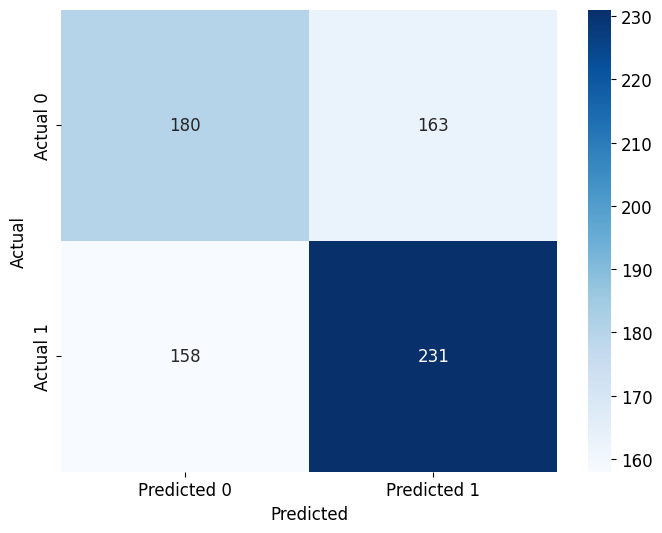

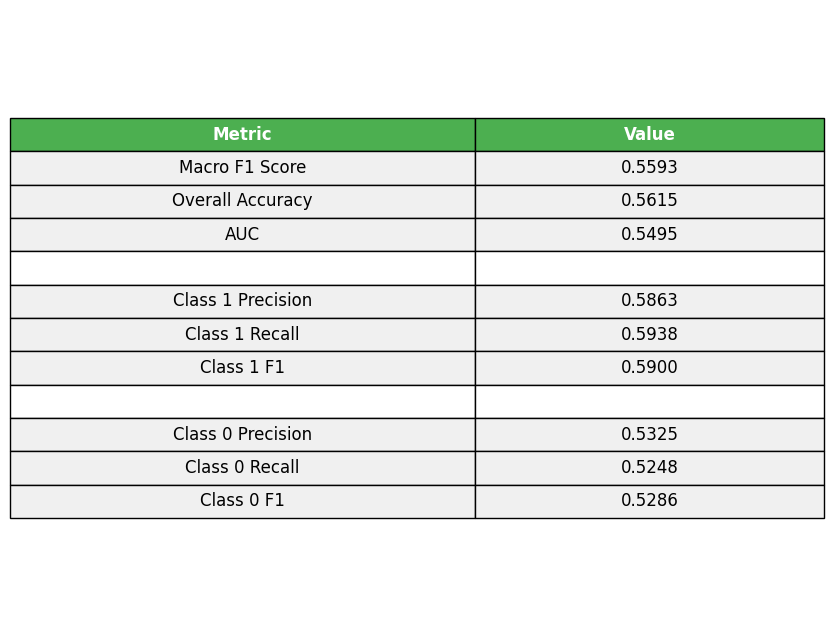


20D_Up Prediction Model - Random Forest Baseline
Starting hyperparameter tuning for 20D model...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters for 20D model: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
Best cross-validation F1 score: 0.5863

20D Model Test Set Results:


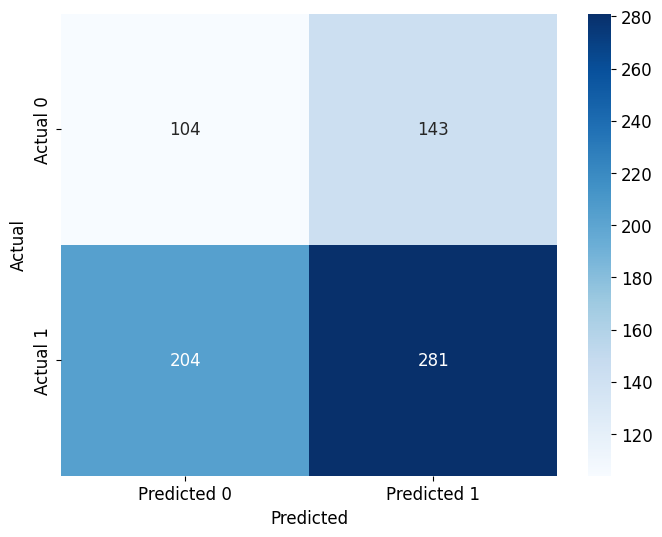

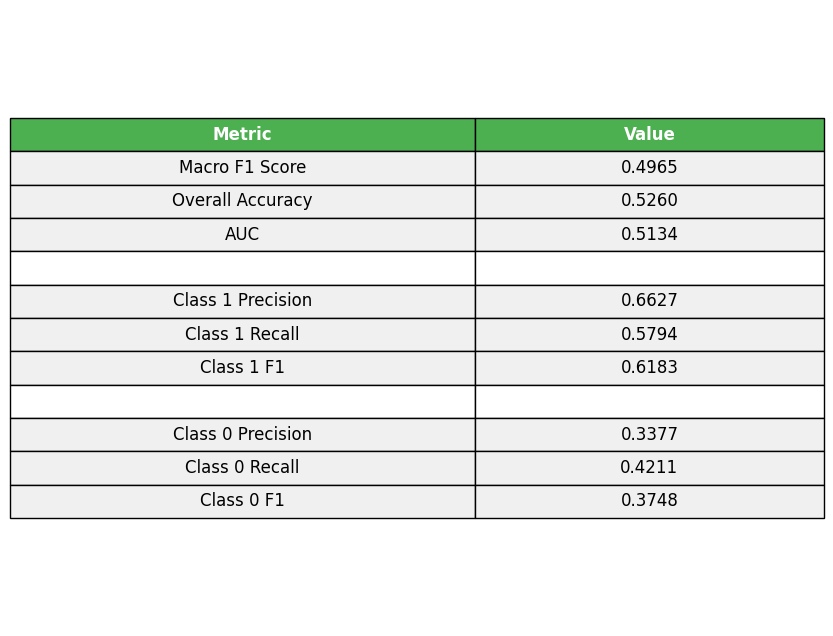


SHAP Feature Importance Analysis
Creating SHAP explainers...
Calculating SHAP values for 1D model...


100%|===================| 1460/1464 [02:44<00:00]        

Calculating SHAP values for 20D model...


100%|===================| 1460/1464 [02:01<00:00]        


1D_Up Model SHAP Analysis


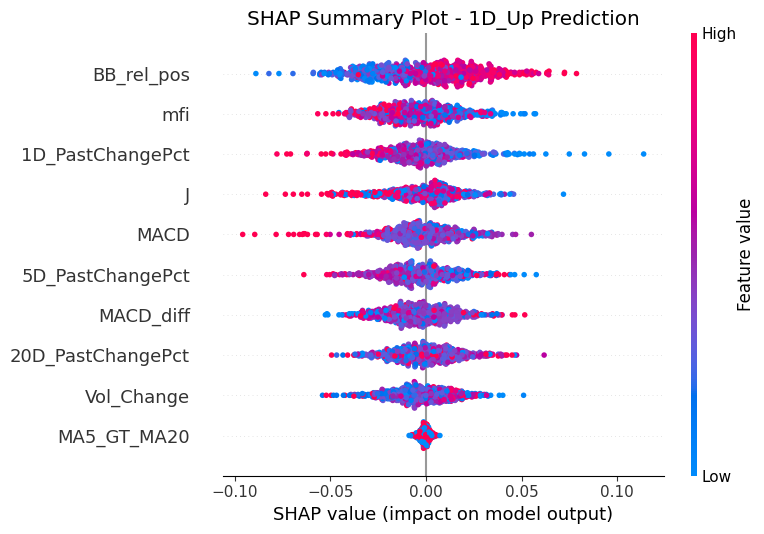

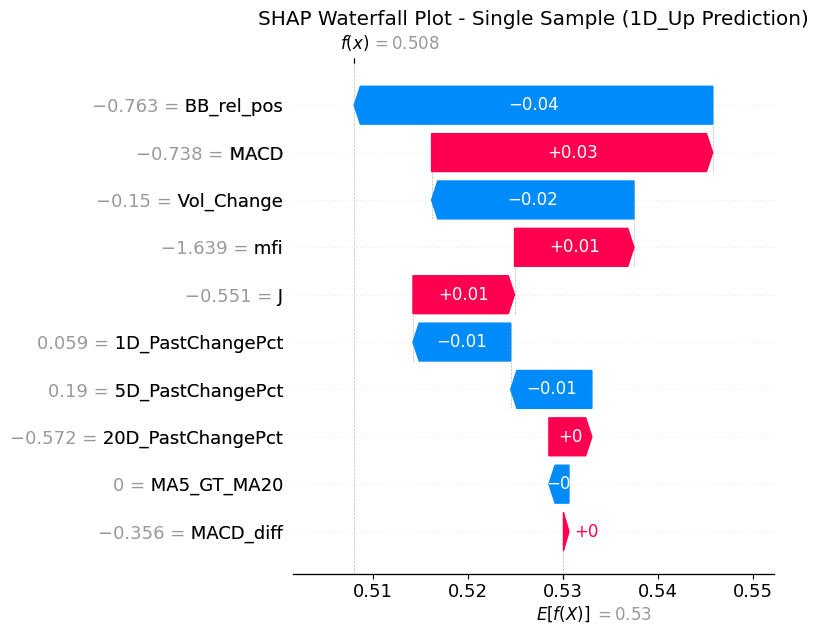


Feature Importance Ranking for 1D_Up Prediction (sorted by absolute value, preserving direction):
Rank Feature              Mean SHAP    |Mean SHAP|  Direction   
---------------------------------------------------------------------------
 1. BB_rel_pos           -0.000628    0.021596 ↓ Negative
 2. mfi                  -0.004049    0.015443 ↓ Negative
 3. 1D_PastChangePct     -0.002402    0.014344 ↓ Negative
 4. J                    -0.002686    0.014276 ↓ Negative
 5. MACD                 -0.002200    0.013436 ↓ Negative
 6. 5D_PastChangePct     -0.003134    0.013365 ↓ Negative
 7. MACD_diff            -0.003843    0.013243 ↓ Negative
 8. 20D_PastChangePct    +0.000012    0.012444 ↑ Positive
 9. Vol_Change           -0.002404    0.012123 ↓ Negative
10. MA5_GT_MA20          -0.000652    0.001735 ↓ Negative

20D_Up Model SHAP Analysis


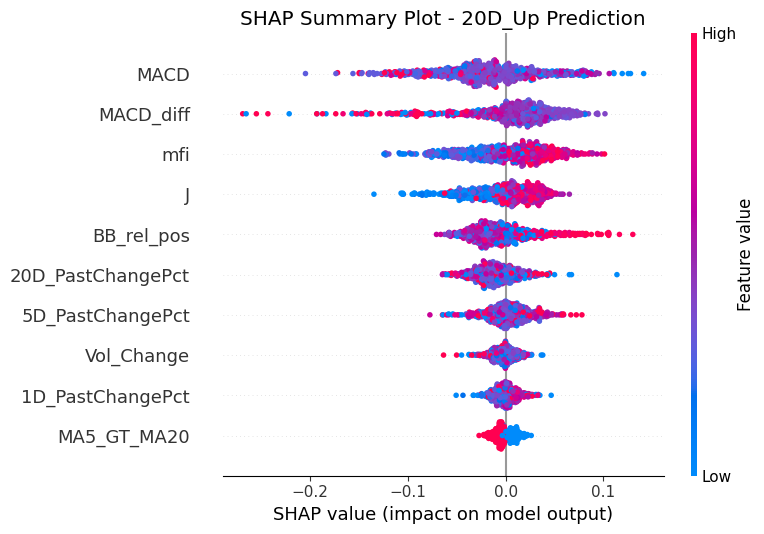

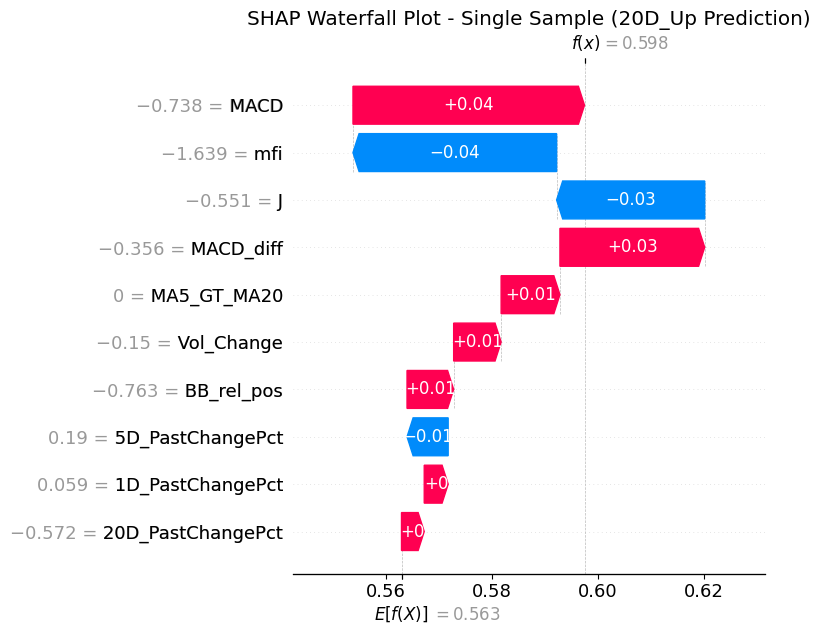


Feature Importance Ranking for 20D_Up Prediction (sorted by absolute value, preserving direction):
Rank Feature              Mean SHAP    |Mean SHAP|  Direction   
---------------------------------------------------------------------------
 1. MACD                 -0.019345    0.043318 ↓ Negative
 2. MACD_diff            +0.002428    0.036954 ↑ Positive
 3. mfi                  +0.000353    0.032983 ↑ Positive
 4. J                    -0.002777    0.025715 ↓ Negative
 5. BB_rel_pos           -0.002692    0.024502 ↓ Negative
 6. 20D_PastChangePct    -0.010233    0.018361 ↓ Negative
 7. 5D_PastChangePct     +0.002835    0.015552 ↑ Positive
 8. Vol_Change           -0.001531    0.008539 ↓ Negative
 9. 1D_PastChangePct     -0.000236    0.008499 ↓ Negative
10. MA5_GT_MA20          -0.001239    0.007521 ↓ Negative


In [16]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import shap
warnings.filterwarnings('ignore')

plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (12, 8)

# Load data
df = pd.read_csv('DATA.csv')

# Define feature columns - Baseline model (only technical indicators)
continuous_features = ['1D_PastChangePct', '5D_PastChangePct', '20D_PastChangePct', 'J', 
                      'mfi', 'MACD', 'MACD_diff',  'BB_rel_pos', 'Vol_Change']
binary_features = ['MA5_GT_MA20']
features = continuous_features + binary_features

# Split data by company in chronological order
train_data_list = []
val_data_list = []
test_data_list = []

for company in df['Company'].unique():
    company_data = df[df['Company'] == company].copy()
    company_data = company_data.sort_values('Date')  # Ensure chronological order
    
    n_company = len(company_data)
    train_size = int(0.7 * n_company)
    val_size = int(0.15 * n_company)
    
    train_data_list.append(company_data.iloc[:train_size])
    val_data_list.append(company_data.iloc[train_size:train_size+val_size])
    test_data_list.append(company_data.iloc[train_size+val_size:])

# Concatenate all companies' data
train_data = pd.concat(train_data_list, ignore_index=True)
val_data = pd.concat(val_data_list, ignore_index=True)
test_data = pd.concat(test_data_list, ignore_index=True)

print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")
print(f"Training set company distribution:\n{train_data['Company'].value_counts().sort_index()}")
print(f"Test set company distribution:\n{test_data['Company'].value_counts().sort_index()}")

# Modified preprocessing function
def preprocess_data(train_df, val_df, test_df, target_col, continuous_features, binary_features):
    all_features = continuous_features + binary_features
    
    # Drop missing values
    train_df = train_df.dropna(subset=all_features + [target_col])
    val_df = val_df.dropna(subset=all_features + [target_col])
    test_df = test_df.dropna(subset=all_features + [target_col])
    
    # Separate continuous and binary features
    X_train_continuous = train_df[continuous_features]
    X_val_continuous = val_df[continuous_features]
    X_test_continuous = test_df[continuous_features]
    
    X_train_binary = train_df[binary_features]
    X_val_binary = val_df[binary_features]
    X_test_binary = test_df[binary_features]
    
    y_train = train_df[target_col]
    y_val = val_df[target_col]
    y_test = test_df[target_col]
    
    # Standardize only continuous features
    scaler = StandardScaler()
    X_train_continuous_scaled = scaler.fit_transform(X_train_continuous)
    X_val_continuous_scaled = scaler.transform(X_val_continuous)
    X_test_continuous_scaled = scaler.transform(X_test_continuous)
    
    # Combine scaled continuous features with unscaled binary features
    X_train_scaled = np.hstack([X_train_continuous_scaled, X_train_binary.values])
    X_val_scaled = np.hstack([X_val_continuous_scaled, X_val_binary.values])
    X_test_scaled = np.hstack([X_test_continuous_scaled, X_test_binary.values])
    
    return X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test, scaler

# Evaluation function
def evaluate_model(y_true, y_pred, y_prob, model_name):
    cm = confusion_matrix(y_true, y_pred)
    
    # Overall metrics
    f1_macro = f1_score(y_true, y_pred, average='macro')
    accuracy = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    
    # Class-specific metrics
    precision_per_class = precision_score(y_true, y_pred, average=None)
    recall_per_class = recall_score(y_true, y_pred, average=None)
    f1_per_class = f1_score(y_true, y_pred, average=None)
    
    # Confusion matrix heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    # Performance metrics table
    plt.figure(figsize=(10, 8))
    plt.axis('tight')
    plt.axis('off')
    
    table_data = [
        ['Metric', 'Value'],
        ['Macro F1 Score', f'{f1_macro:.4f}'],
        ['Overall Accuracy', f'{accuracy:.4f}'],
        ['AUC', f'{auc:.4f}'],
        ['', ''],  # Empty row for separation
        ['Class 1 Precision', f'{precision_per_class[1]:.4f}'],
        ['Class 1 Recall', f'{recall_per_class[1]:.4f}'],
        ['Class 1 F1', f'{f1_per_class[1]:.4f}'],
        ['', ''],  # Empty row for separation
        ['Class 0 Precision', f'{precision_per_class[0]:.4f}'],
        ['Class 0 Recall', f'{recall_per_class[0]:.4f}'],
        ['Class 0 F1', f'{f1_per_class[0]:.4f}']
    ]
    
    table = plt.table(cellText=table_data[1:], colLabels=table_data[0],
                     cellLoc='center', loc='center',
                     colWidths=[0.4, 0.3])
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.5, 2)
    
    # Set table style
    for i in range(len(table_data)):
        for j in range(len(table_data[0])):
            cell = table[(i, j)]
            if i == 0:  # header
                cell.set_facecolor('#4CAF50')
                cell.set_text_props(weight='bold', color='white')
            elif len(table_data[i]) > 0 and table_data[i][0] == '':  # empty rows
                cell.set_facecolor('#ffffff')
                cell.set_text_props(color='white')
            else:
                cell.set_facecolor('#f0f0f0')
    
    plt.show()
    
    return {'confusion_matrix': cm, 'f1_macro': f1_macro, 'accuracy': accuracy, 'auc': auc,
            'class_0_precision': precision_per_class[0], 'class_0_recall': recall_per_class[0], 'class_0_f1': f1_per_class[0],
            'class_1_precision': precision_per_class[1], 'class_1_recall': recall_per_class[1], 'class_1_f1': f1_per_class[1]}

# 1D_Up prediction
print("=" * 60)
print("1D_Up Prediction Model - Random Forest Baseline")
print("=" * 60)

X_train_1d, y_train_1d, X_val_1d, y_val_1d, X_test_1d, y_test_1d, scaler_1d = preprocess_data(
    train_data, val_data, test_data, '1D_Up', continuous_features, binary_features)


tscv = TimeSeriesSplit(n_splits=5)
param_grid = {
    'n_estimators': [300, 400, 500], 
    'max_depth': [ 6, 8,10, None],    
    'min_samples_split': [2, 5, 8], 
    'min_samples_leaf': [1, 2, 3],  
    'max_features': ['sqrt', 'log2'] 
}

print("Starting hyperparameter tuning for 1D model...")
grid_search_1d = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1,class_weight='balanced'),
    param_grid, cv=tscv, scoring='f1', n_jobs=-1, verbose=1
)

grid_search_1d.fit(X_train_1d, y_train_1d)
best_params_1d = grid_search_1d.best_params_
print(f"Best parameters for 1D model: {best_params_1d}")
print(f"Best cross-validation F1 score: {grid_search_1d.best_score_:.4f}")

# Train final model with best parameters
final_model_1d = RandomForestClassifier(**best_params_1d, random_state=42, n_jobs=-1,class_weight='balanced')
final_model_1d.fit(X_train_1d, y_train_1d)

# Evaluate on test set
y_pred_1d = final_model_1d.predict(X_test_1d)
y_prob_1d = final_model_1d.predict_proba(X_test_1d)[:, 1]

print("\n1D Model Test Set Results:")
results_1d = evaluate_model(y_test_1d, y_pred_1d, y_prob_1d, "1D_Up Prediction")

# 20D_Up prediction
print("\n" + "=" * 60)
print("20D_Up Prediction Model - Random Forest Baseline")
print("=" * 60)

X_train_20d, y_train_20d, X_val_20d, y_val_20d, X_test_20d, y_test_20d, scaler_20d = preprocess_data(
    train_data, val_data, test_data, '20D_Up', continuous_features, binary_features)

print("Starting hyperparameter tuning for 20D model...")
grid_search_20d = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1,class_weight='balanced'),
    param_grid, cv=tscv, scoring='f1', n_jobs=-1, verbose=1
)

grid_search_20d.fit(X_train_20d, y_train_20d)
best_params_20d = grid_search_20d.best_params_
print(f"Best parameters for 20D model: {best_params_20d}")
print(f"Best cross-validation F1 score: {grid_search_20d.best_score_:.4f}")

# Train final model with best parameters
final_model_20d = RandomForestClassifier(**best_params_20d, random_state=42, n_jobs=-1,class_weight='balanced')
final_model_20d.fit(X_train_20d, y_train_20d)

# Evaluate on test set
y_pred_20d = final_model_20d.predict(X_test_20d)
y_prob_20d = final_model_20d.predict_proba(X_test_20d)[:, 1]

print("\n20D Model Test Set Results:")
results_20d = evaluate_model(y_test_20d, y_pred_20d, y_prob_20d, "20D_Up Prediction")

# SHAP Feature Importance Analysis
print("\n" + "=" * 60)
print("SHAP Feature Importance Analysis")
print("=" * 60)

# Get feature names
feature_names = continuous_features + binary_features
feature_names_array = np.array(feature_names)

# Create SHAP explainers for both models
print("Creating SHAP explainers...")
explainer_1d = shap.Explainer(final_model_1d, X_train_1d)
explainer_20d = shap.Explainer(final_model_20d, X_train_20d)

# Calculate SHAP values for test sets
print("Calculating SHAP values for 1D model...")
shap_values_1d = explainer_1d(X_test_1d)

print("Calculating SHAP values for 20D model...")
shap_values_20d = explainer_20d(X_test_20d)

# 1D Model SHAP Analysis
print("\n" + "=" * 40)
print("1D_Up Model SHAP Analysis")
print("=" * 40)

# Summary plot for 1D model - use only positive class SHAP values
if len(shap_values_1d.values.shape) == 3:
    # Multi-class case - use positive class (class 1)
    shap_vals_1d = shap_values_1d.values[:, :, 1]
else:
    # Binary case - use all values
    shap_vals_1d = shap_values_1d.values

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_vals_1d, X_test_1d, feature_names=feature_names_array, show=False)
plt.title('SHAP Summary Plot - 1D_Up Prediction')
plt.tight_layout()
plt.show()

# Waterfall plot for a single sample (1D model)
plt.figure(figsize=(10, 6))
if len(shap_values_1d.values.shape) == 3:
    # For multi-class, create a new Explanation object for single class
    sample_explanation = shap.Explanation(
        values=shap_values_1d.values[0, :, 1],
        base_values=shap_values_1d.base_values[0, 1] if hasattr(shap_values_1d.base_values, 'shape') and len(shap_values_1d.base_values.shape) > 1 else shap_values_1d.base_values[0],
        data=shap_values_1d.data[0],
        feature_names=feature_names_array
    )
else:
    sample_explanation = shap_values_1d[0]

shap.waterfall_plot(sample_explanation, show=False)
plt.title('SHAP Waterfall Plot - Single Sample (1D_Up Prediction)')
plt.tight_layout()
plt.show()

# Feature importance ranking table for 1D model
if len(shap_values_1d.values.shape) == 3:
    mean_shap_1d = np.mean(shap_values_1d.values[:, :, 1], axis=0)
    abs_mean_shap_1d = np.mean(np.abs(shap_values_1d.values[:, :, 1]), axis=0)
else:
    mean_shap_1d = np.mean(shap_values_1d.values, axis=0)
    abs_mean_shap_1d = np.mean(np.abs(shap_values_1d.values), axis=0)

importance_df_1d = pd.DataFrame({
    'Feature': feature_names,
    'Mean_SHAP': mean_shap_1d,
    'Abs_Mean_SHAP': abs_mean_shap_1d
}).sort_values('Abs_Mean_SHAP', ascending=False)

print("\nFeature Importance Ranking for 1D_Up Prediction (sorted by absolute value, preserving direction):")
print("=" * 75)
print(f"{'Rank':<4} {'Feature':<20} {'Mean SHAP':<12} {'|Mean SHAP|':<12} {'Direction':<12}")
print("-" * 75)

for i, (_, row) in enumerate(importance_df_1d.iterrows(), 1):
    direction = "↑ Positive" if row['Mean_SHAP'] > 0 else "↓ Negative"
    print(f"{i:>2}. {row['Feature']:<20} {row['Mean_SHAP']:>+9.6f} {row['Abs_Mean_SHAP']:>11.6f} {direction}")

# 20D Model SHAP Analysis
print("\n" + "=" * 40)
print("20D_Up Model SHAP Analysis")
print("=" * 40)

# Summary plot for 20D model - use only positive class SHAP values
if len(shap_values_20d.values.shape) == 3:
    # Multi-class case - use positive class (class 1)
    shap_vals_20d = shap_values_20d.values[:, :, 1]
else:
    # Binary case - use all values
    shap_vals_20d = shap_values_20d.values

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_vals_20d, X_test_20d, feature_names=feature_names_array, show=False)
plt.title('SHAP Summary Plot - 20D_Up Prediction')
plt.tight_layout()
plt.show()

# Waterfall plot for a single sample (20D model)
plt.figure(figsize=(10, 6))
if len(shap_values_20d.values.shape) == 3:
    # For multi-class, create a new Explanation object for single class
    sample_explanation = shap.Explanation(
        values=shap_values_20d.values[0, :, 1],
        base_values=shap_values_20d.base_values[0, 1] if hasattr(shap_values_20d.base_values, 'shape') and len(shap_values_20d.base_values.shape) > 1 else shap_values_20d.base_values[0],
        data=shap_values_20d.data[0],
        feature_names=feature_names_array
    )
else:
    sample_explanation = shap_values_20d[0]

shap.waterfall_plot(sample_explanation, show=False)
plt.title('SHAP Waterfall Plot - Single Sample (20D_Up Prediction)')
plt.tight_layout()
plt.show()

# Feature importance ranking table for 20D model
if len(shap_values_20d.values.shape) == 3:
    mean_shap_20d = np.mean(shap_values_20d.values[:, :, 1], axis=0)
    abs_mean_shap_20d = np.mean(np.abs(shap_values_20d.values[:, :, 1]), axis=0)
else:
    mean_shap_20d = np.mean(shap_values_20d.values, axis=0)
    abs_mean_shap_20d = np.mean(np.abs(shap_values_20d.values), axis=0)

importance_df_20d = pd.DataFrame({
    'Feature': feature_names,
    'Mean_SHAP': mean_shap_20d,
    'Abs_Mean_SHAP': abs_mean_shap_20d
}).sort_values('Abs_Mean_SHAP', ascending=False)

print("\nFeature Importance Ranking for 20D_Up Prediction (sorted by absolute value, preserving direction):")
print("=" * 75)
print(f"{'Rank':<4} {'Feature':<20} {'Mean SHAP':<12} {'|Mean SHAP|':<12} {'Direction':<12}")
print("-" * 75)

for i, (_, row) in enumerate(importance_df_20d.iterrows(), 1):
    direction = "↑ Positive" if row['Mean_SHAP'] > 0 else "↓ Negative"
    print(f"{i:>2}. {row['Feature']:<20} {row['Mean_SHAP']:>+9.6f} {row['Abs_Mean_SHAP']:>11.6f} {direction}")

## interest

Training set size: 3404
Validation set size: 728
Test set size: 732
Training set company distribution:
Company
Alibaba    851
Apple      851
Philips    851
Tesla      851
Name: count, dtype: int64
Test set company distribution:
Company
Alibaba    183
Apple      183
Philips    183
Tesla      183
Name: count, dtype: int64
1D_Up Prediction Model - Random Forest Baseline
Starting hyperparameter tuning for 1D model...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters for 1D model: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Best cross-validation F1 score: 0.5399

1D Model Test Set Results:


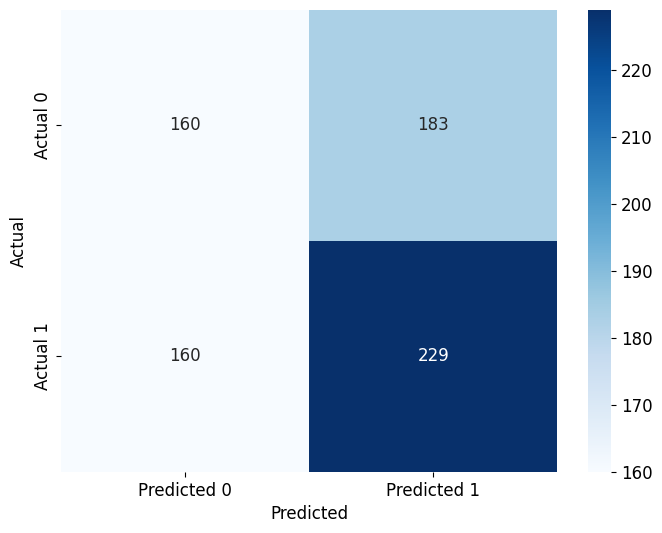

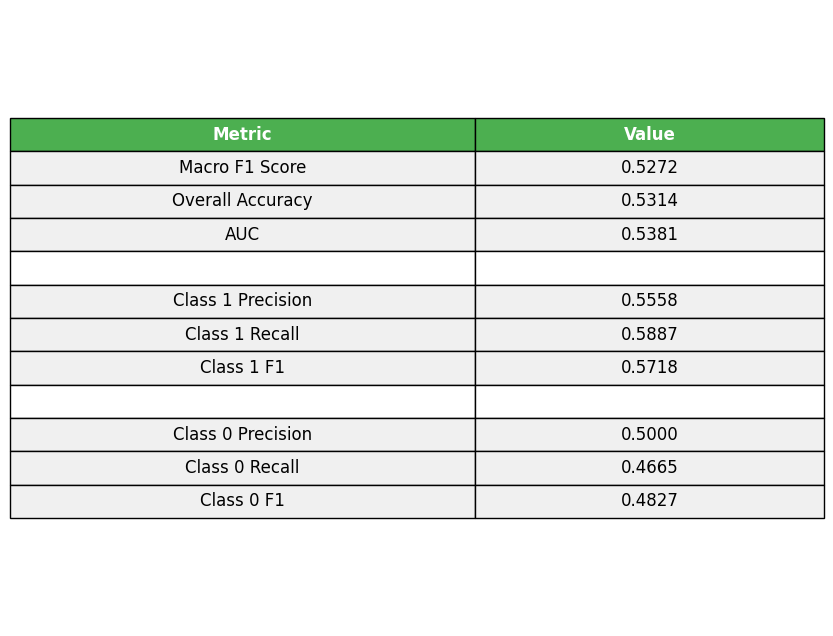


20D_Up Prediction Model - Random Forest Baseline
Starting hyperparameter tuning for 20D model...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters for 20D model: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Best cross-validation F1 score: 0.6045

20D Model Test Set Results:


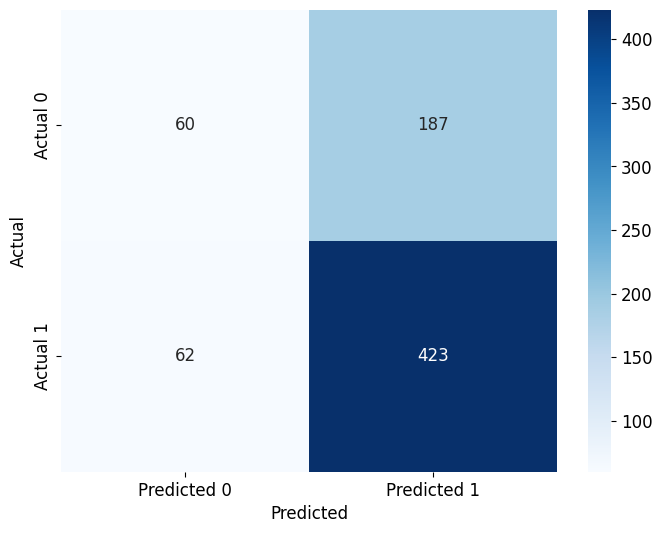

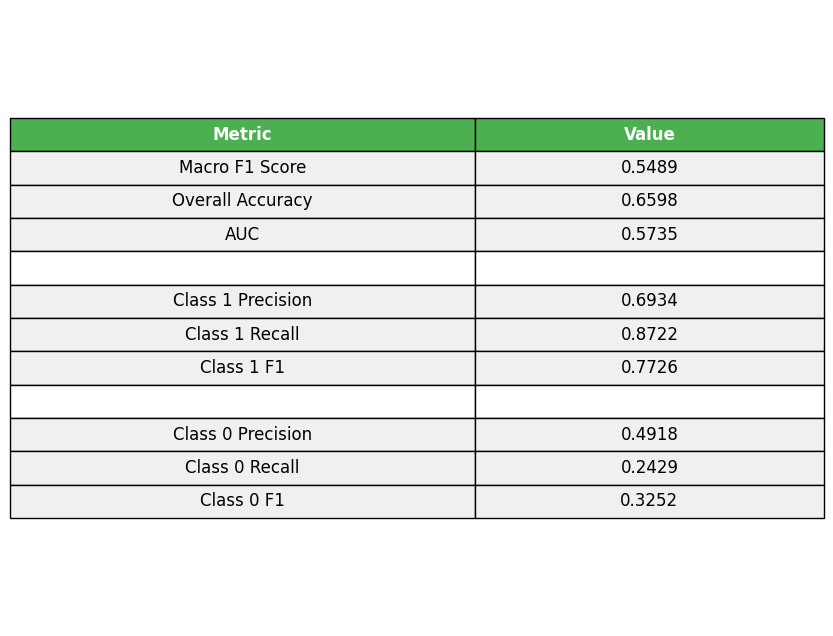


SHAP Feature Importance Analysis
Creating SHAP explainers...
Calculating SHAP values for 1D model...


 99%|===================| 1455/1464 [01:31<00:00]        

Calculating SHAP values for 20D model...


 99%|===================| 1455/1464 [02:11<00:00]        


1D_Up Model SHAP Analysis


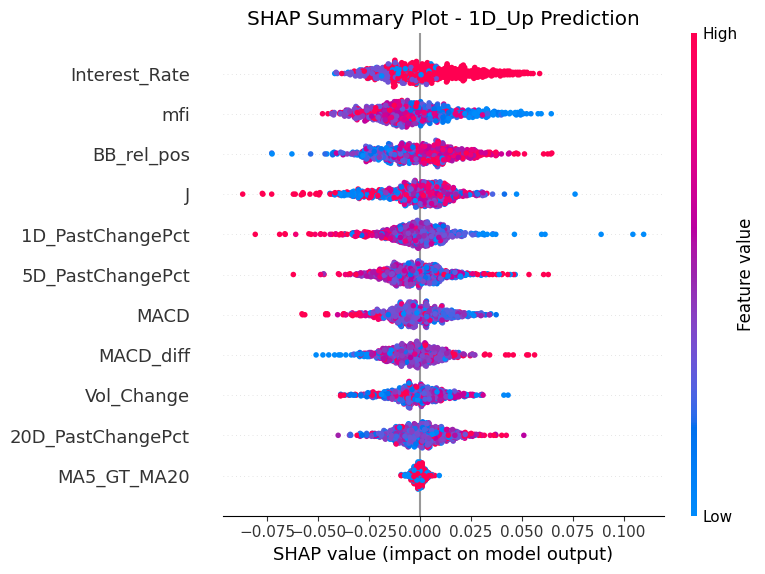

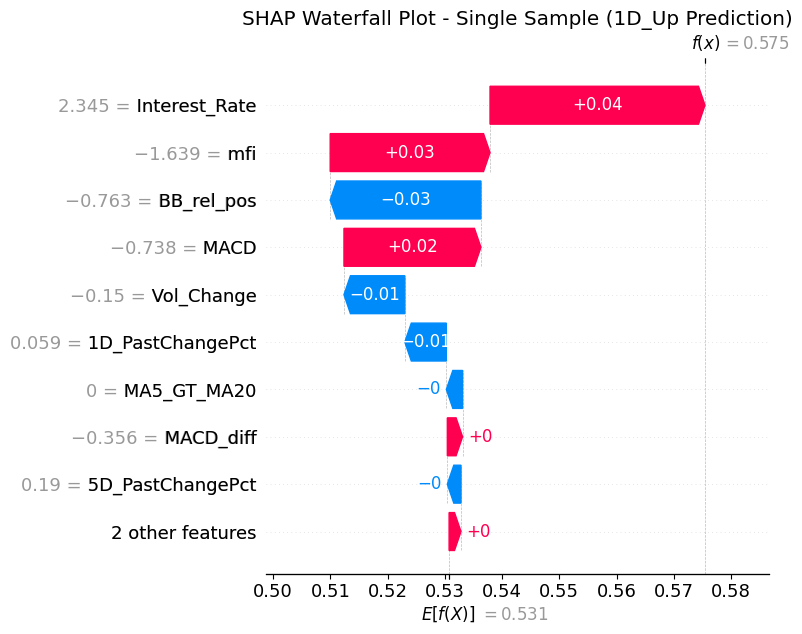


Feature Importance Ranking for 1D_Up Prediction (sorted by absolute value, preserving direction):
Rank Feature              Mean SHAP    |Mean SHAP|  Direction   
---------------------------------------------------------------------------
 1. Interest_Rate        +0.002787    0.016161 ↑ Positive
 2. mfi                  -0.003097    0.015992 ↓ Negative
 3. BB_rel_pos           -0.001022    0.014830 ↓ Negative
 4. J                    -0.003282    0.013515 ↓ Negative
 5. 1D_PastChangePct     -0.002440    0.011528 ↓ Negative
 6. 5D_PastChangePct     -0.002344    0.011079 ↓ Negative
 7. MACD                 -0.002358    0.010971 ↓ Negative
 8. MACD_diff            -0.003463    0.010405 ↓ Negative
 9. Vol_Change           -0.001764    0.009648 ↓ Negative
10. 20D_PastChangePct    +0.000261    0.009523 ↑ Positive
11. MA5_GT_MA20          -0.000520    0.002025 ↓ Negative

20D_Up Model SHAP Analysis


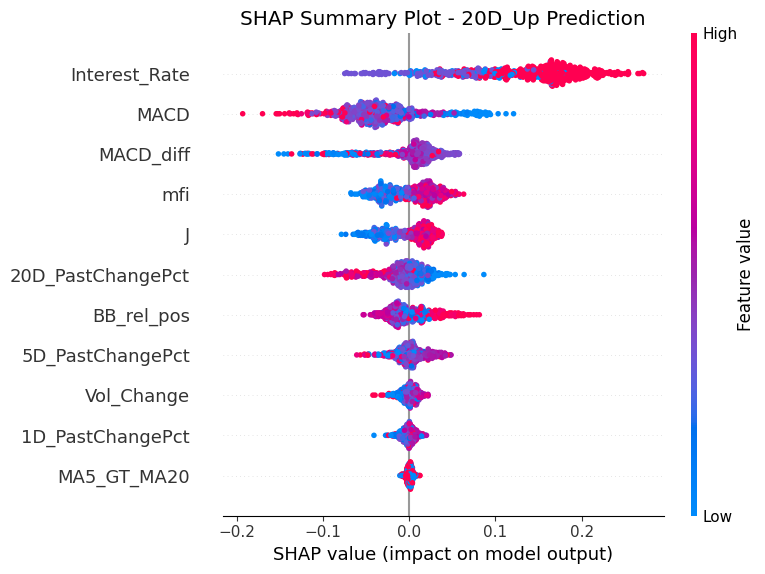

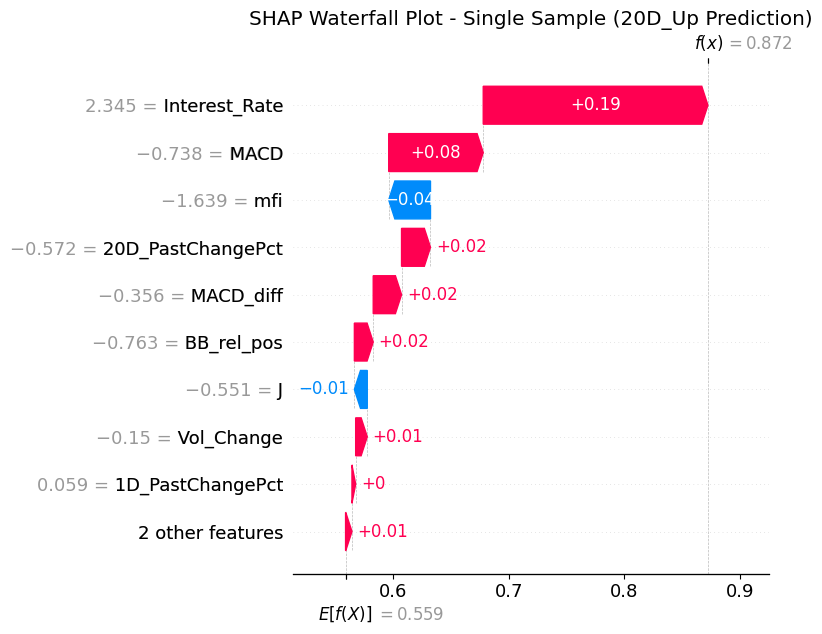


Feature Importance Ranking for 20D_Up Prediction (sorted by absolute value, preserving direction):
Rank Feature              Mean SHAP    |Mean SHAP|  Direction   
---------------------------------------------------------------------------
 1. Interest_Rate        +0.126347    0.130265 ↑ Positive
 2. MACD                 -0.031401    0.046277 ↓ Negative
 3. MACD_diff            -0.001209    0.025948 ↓ Negative
 4. mfi                  +0.000630    0.024594 ↑ Positive
 5. J                    -0.002208    0.022252 ↓ Negative
 6. 20D_PastChangePct    -0.007427    0.019657 ↓ Negative
 7. BB_rel_pos           +0.001349    0.019463 ↑ Positive
 8. 5D_PastChangePct     +0.001624    0.012241 ↑ Positive
 9. Vol_Change           +0.000441    0.006686 ↑ Positive
10. 1D_PastChangePct     -0.000845    0.005467 ↓ Negative
11. MA5_GT_MA20          +0.000650    0.002451 ↑ Positive


In [19]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import shap
warnings.filterwarnings('ignore')

plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (12, 8)

# Load data
df = pd.read_csv('DATA.csv')

# Define feature columns 
continuous_features = ['1D_PastChangePct', '5D_PastChangePct', '20D_PastChangePct', 'J', 
                      'mfi', 'MACD', 'MACD_diff',  'BB_rel_pos', 'Vol_Change',"Interest_Rate"]
binary_features = ['MA5_GT_MA20']
features = continuous_features + binary_features

# Split data by company in chronological order
train_data_list = []
val_data_list = []
test_data_list = []

for company in df['Company'].unique():
    company_data = df[df['Company'] == company].copy()
    company_data = company_data.sort_values('Date')  # Ensure chronological order
    
    n_company = len(company_data)
    train_size = int(0.7 * n_company)
    val_size = int(0.15 * n_company)
    
    train_data_list.append(company_data.iloc[:train_size])
    val_data_list.append(company_data.iloc[train_size:train_size+val_size])
    test_data_list.append(company_data.iloc[train_size+val_size:])

# Concatenate all companies' data
train_data = pd.concat(train_data_list, ignore_index=True)
val_data = pd.concat(val_data_list, ignore_index=True)
test_data = pd.concat(test_data_list, ignore_index=True)

print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")
print(f"Training set company distribution:\n{train_data['Company'].value_counts().sort_index()}")
print(f"Test set company distribution:\n{test_data['Company'].value_counts().sort_index()}")

# Modified preprocessing function
def preprocess_data(train_df, val_df, test_df, target_col, continuous_features, binary_features):
    all_features = continuous_features + binary_features
    
    # Drop missing values
    train_df = train_df.dropna(subset=all_features + [target_col])
    val_df = val_df.dropna(subset=all_features + [target_col])
    test_df = test_df.dropna(subset=all_features + [target_col])
    
    # Separate continuous and binary features
    X_train_continuous = train_df[continuous_features]
    X_val_continuous = val_df[continuous_features]
    X_test_continuous = test_df[continuous_features]
    
    X_train_binary = train_df[binary_features]
    X_val_binary = val_df[binary_features]
    X_test_binary = test_df[binary_features]
    
    y_train = train_df[target_col]
    y_val = val_df[target_col]
    y_test = test_df[target_col]
    
    # Standardize only continuous features
    scaler = StandardScaler()
    X_train_continuous_scaled = scaler.fit_transform(X_train_continuous)
    X_val_continuous_scaled = scaler.transform(X_val_continuous)
    X_test_continuous_scaled = scaler.transform(X_test_continuous)
    
    # Combine scaled continuous features with unscaled binary features
    X_train_scaled = np.hstack([X_train_continuous_scaled, X_train_binary.values])
    X_val_scaled = np.hstack([X_val_continuous_scaled, X_val_binary.values])
    X_test_scaled = np.hstack([X_test_continuous_scaled, X_test_binary.values])
    
    return X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test, scaler

# Evaluation function
def evaluate_model(y_true, y_pred, y_prob, model_name):
    cm = confusion_matrix(y_true, y_pred)
    
    # Overall metrics
    f1_macro = f1_score(y_true, y_pred, average='macro')
    accuracy = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    
    # Class-specific metrics
    precision_per_class = precision_score(y_true, y_pred, average=None)
    recall_per_class = recall_score(y_true, y_pred, average=None)
    f1_per_class = f1_score(y_true, y_pred, average=None)
    
    # Confusion matrix heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    # Performance metrics table
    plt.figure(figsize=(10, 8))
    plt.axis('tight')
    plt.axis('off')
    
    table_data = [
        ['Metric', 'Value'],
        ['Macro F1 Score', f'{f1_macro:.4f}'],
        ['Overall Accuracy', f'{accuracy:.4f}'],
        ['AUC', f'{auc:.4f}'],
        ['', ''],  # Empty row for separation
        ['Class 1 Precision', f'{precision_per_class[1]:.4f}'],
        ['Class 1 Recall', f'{recall_per_class[1]:.4f}'],
        ['Class 1 F1', f'{f1_per_class[1]:.4f}'],
        ['', ''],  # Empty row for separation
        ['Class 0 Precision', f'{precision_per_class[0]:.4f}'],
        ['Class 0 Recall', f'{recall_per_class[0]:.4f}'],
        ['Class 0 F1', f'{f1_per_class[0]:.4f}']
    ]
    
    table = plt.table(cellText=table_data[1:], colLabels=table_data[0],
                     cellLoc='center', loc='center',
                     colWidths=[0.4, 0.3])
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.5, 2)
    
    # Set table style
    for i in range(len(table_data)):
        for j in range(len(table_data[0])):
            cell = table[(i, j)]
            if i == 0:  # header
                cell.set_facecolor('#4CAF50')
                cell.set_text_props(weight='bold', color='white')
            elif len(table_data[i]) > 0 and table_data[i][0] == '':  # empty rows
                cell.set_facecolor('#ffffff')
                cell.set_text_props(color='white')
            else:
                cell.set_facecolor('#f0f0f0')
    
    plt.show()
    
    return {'confusion_matrix': cm, 'f1_macro': f1_macro, 'accuracy': accuracy, 'auc': auc,
            'class_0_precision': precision_per_class[0], 'class_0_recall': recall_per_class[0], 'class_0_f1': f1_per_class[0],
            'class_1_precision': precision_per_class[1], 'class_1_recall': recall_per_class[1], 'class_1_f1': f1_per_class[1]}

# 1D_Up prediction
print("=" * 60)
print("1D_Up Prediction Model - Random Forest Baseline")
print("=" * 60)

X_train_1d, y_train_1d, X_val_1d, y_val_1d, X_test_1d, y_test_1d, scaler_1d = preprocess_data(
    train_data, val_data, test_data, '1D_Up', continuous_features, binary_features)


tscv = TimeSeriesSplit(n_splits=5)
param_grid = {
    'n_estimators': [300, 400, 500], 
    'max_depth': [ 6, 8,10, None],    
    'min_samples_split': [2, 5, 8], 
    'min_samples_leaf': [1, 2, 3],  
    'max_features': ['sqrt', 'log2'] 
}

print("Starting hyperparameter tuning for 1D model...")
grid_search_1d = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1,class_weight='balanced'),
    param_grid, cv=tscv, scoring='f1', n_jobs=-1, verbose=1
)

grid_search_1d.fit(X_train_1d, y_train_1d)
best_params_1d = grid_search_1d.best_params_
print(f"Best parameters for 1D model: {best_params_1d}")
print(f"Best cross-validation F1 score: {grid_search_1d.best_score_:.4f}")

# Train final model with best parameters
final_model_1d = RandomForestClassifier(**best_params_1d, random_state=42, n_jobs=-1,class_weight='balanced')
final_model_1d.fit(X_train_1d, y_train_1d)

# Evaluate on test set
y_pred_1d = final_model_1d.predict(X_test_1d)
y_prob_1d = final_model_1d.predict_proba(X_test_1d)[:, 1]

print("\n1D Model Test Set Results:")
results_1d = evaluate_model(y_test_1d, y_pred_1d, y_prob_1d, "1D_Up Prediction")

# 20D_Up prediction
print("\n" + "=" * 60)
print("20D_Up Prediction Model - Random Forest Baseline")
print("=" * 60)

X_train_20d, y_train_20d, X_val_20d, y_val_20d, X_test_20d, y_test_20d, scaler_20d = preprocess_data(
    train_data, val_data, test_data, '20D_Up', continuous_features, binary_features)

print("Starting hyperparameter tuning for 20D model...")
grid_search_20d = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1,class_weight='balanced'),
    param_grid, cv=tscv, scoring='f1', n_jobs=-1, verbose=1
)

grid_search_20d.fit(X_train_20d, y_train_20d)
best_params_20d = grid_search_20d.best_params_
print(f"Best parameters for 20D model: {best_params_20d}")
print(f"Best cross-validation F1 score: {grid_search_20d.best_score_:.4f}")

# Train final model with best parameters
final_model_20d = RandomForestClassifier(**best_params_20d, random_state=42, n_jobs=-1,class_weight='balanced')
final_model_20d.fit(X_train_20d, y_train_20d)

# Evaluate on test set
y_pred_20d = final_model_20d.predict(X_test_20d)
y_prob_20d = final_model_20d.predict_proba(X_test_20d)[:, 1]

print("\n20D Model Test Set Results:")
results_20d = evaluate_model(y_test_20d, y_pred_20d, y_prob_20d, "20D_Up Prediction")

# SHAP Feature Importance Analysis
print("\n" + "=" * 60)
print("SHAP Feature Importance Analysis")
print("=" * 60)

# Get feature names
feature_names = continuous_features + binary_features
feature_names_array = np.array(feature_names)

# Create SHAP explainers for both models
print("Creating SHAP explainers...")
explainer_1d = shap.Explainer(final_model_1d, X_train_1d)
explainer_20d = shap.Explainer(final_model_20d, X_train_20d)

# Calculate SHAP values for test sets
print("Calculating SHAP values for 1D model...")
shap_values_1d = explainer_1d(X_test_1d,check_additivity=False)

print("Calculating SHAP values for 20D model...")
shap_values_20d = explainer_20d(X_test_20d,check_additivity=False)

# 1D Model SHAP Analysis
print("\n" + "=" * 40)
print("1D_Up Model SHAP Analysis")
print("=" * 40)

# Summary plot for 1D model - use only positive class SHAP values
if len(shap_values_1d.values.shape) == 3:
    # Multi-class case - use positive class (class 1)
    shap_vals_1d = shap_values_1d.values[:, :, 1]
else:
    # Binary case - use all values
    shap_vals_1d = shap_values_1d.values

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_vals_1d, X_test_1d, feature_names=feature_names_array, show=False)
plt.title('SHAP Summary Plot - 1D_Up Prediction')
plt.tight_layout()
plt.show()

# Waterfall plot for a single sample (1D model)
plt.figure(figsize=(10, 6))
if len(shap_values_1d.values.shape) == 3:
    # For multi-class, create a new Explanation object for single class
    sample_explanation = shap.Explanation(
        values=shap_values_1d.values[0, :, 1],
        base_values=shap_values_1d.base_values[0, 1] if hasattr(shap_values_1d.base_values, 'shape') and len(shap_values_1d.base_values.shape) > 1 else shap_values_1d.base_values[0],
        data=shap_values_1d.data[0],
        feature_names=feature_names_array
    )
else:
    sample_explanation = shap_values_1d[0]

shap.waterfall_plot(sample_explanation, show=False)
plt.title('SHAP Waterfall Plot - Single Sample (1D_Up Prediction)')
plt.tight_layout()
plt.show()

# Feature importance ranking table for 1D model
if len(shap_values_1d.values.shape) == 3:
    mean_shap_1d = np.mean(shap_values_1d.values[:, :, 1], axis=0)
    abs_mean_shap_1d = np.mean(np.abs(shap_values_1d.values[:, :, 1]), axis=0)
else:
    mean_shap_1d = np.mean(shap_values_1d.values, axis=0)
    abs_mean_shap_1d = np.mean(np.abs(shap_values_1d.values), axis=0)

importance_df_1d = pd.DataFrame({
    'Feature': feature_names,
    'Mean_SHAP': mean_shap_1d,
    'Abs_Mean_SHAP': abs_mean_shap_1d
}).sort_values('Abs_Mean_SHAP', ascending=False)

print("\nFeature Importance Ranking for 1D_Up Prediction (sorted by absolute value, preserving direction):")
print("=" * 75)
print(f"{'Rank':<4} {'Feature':<20} {'Mean SHAP':<12} {'|Mean SHAP|':<12} {'Direction':<12}")
print("-" * 75)

for i, (_, row) in enumerate(importance_df_1d.iterrows(), 1):
    direction = "↑ Positive" if row['Mean_SHAP'] > 0 else "↓ Negative"
    print(f"{i:>2}. {row['Feature']:<20} {row['Mean_SHAP']:>+9.6f} {row['Abs_Mean_SHAP']:>11.6f} {direction}")

# 20D Model SHAP Analysis
print("\n" + "=" * 40)
print("20D_Up Model SHAP Analysis")
print("=" * 40)

# Summary plot for 20D model - use only positive class SHAP values
if len(shap_values_20d.values.shape) == 3:
    # Multi-class case - use positive class (class 1)
    shap_vals_20d = shap_values_20d.values[:, :, 1]
else:
    # Binary case - use all values
    shap_vals_20d = shap_values_20d.values

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_vals_20d, X_test_20d, feature_names=feature_names_array, show=False)
plt.title('SHAP Summary Plot - 20D_Up Prediction')
plt.tight_layout()
plt.show()

# Waterfall plot for a single sample (20D model)
plt.figure(figsize=(10, 6))
if len(shap_values_20d.values.shape) == 3:
    # For multi-class, create a new Explanation object for single class
    sample_explanation = shap.Explanation(
        values=shap_values_20d.values[0, :, 1],
        base_values=shap_values_20d.base_values[0, 1] if hasattr(shap_values_20d.base_values, 'shape') and len(shap_values_20d.base_values.shape) > 1 else shap_values_20d.base_values[0],
        data=shap_values_20d.data[0],
        feature_names=feature_names_array
    )
else:
    sample_explanation = shap_values_20d[0]

shap.waterfall_plot(sample_explanation, show=False)
plt.title('SHAP Waterfall Plot - Single Sample (20D_Up Prediction)')
plt.tight_layout()
plt.show()

# Feature importance ranking table for 20D model
if len(shap_values_20d.values.shape) == 3:
    mean_shap_20d = np.mean(shap_values_20d.values[:, :, 1], axis=0)
    abs_mean_shap_20d = np.mean(np.abs(shap_values_20d.values[:, :, 1]), axis=0)
else:
    mean_shap_20d = np.mean(shap_values_20d.values, axis=0)
    abs_mean_shap_20d = np.mean(np.abs(shap_values_20d.values), axis=0)

importance_df_20d = pd.DataFrame({
    'Feature': feature_names,
    'Mean_SHAP': mean_shap_20d,
    'Abs_Mean_SHAP': abs_mean_shap_20d
}).sort_values('Abs_Mean_SHAP', ascending=False)

print("\nFeature Importance Ranking for 20D_Up Prediction (sorted by absolute value, preserving direction):")
print("=" * 75)
print(f"{'Rank':<4} {'Feature':<20} {'Mean SHAP':<12} {'|Mean SHAP|':<12} {'Direction':<12}")
print("-" * 75)

for i, (_, row) in enumerate(importance_df_20d.iterrows(), 1):
    direction = "↑ Positive" if row['Mean_SHAP'] > 0 else "↓ Negative"
    print(f"{i:>2}. {row['Feature']:<20} {row['Mean_SHAP']:>+9.6f} {row['Abs_Mean_SHAP']:>11.6f} {direction}")

## BTC

Training set size: 3404
Validation set size: 728
Test set size: 732
Training set company distribution:
Company
Alibaba    851
Apple      851
Philips    851
Tesla      851
Name: count, dtype: int64
Test set company distribution:
Company
Alibaba    183
Apple      183
Philips    183
Tesla      183
Name: count, dtype: int64
1D_Up Prediction Model - Random Forest Baseline
Starting hyperparameter tuning for 1D model...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters for 1D model: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Best cross-validation F1 score: 0.5525

1D Model Test Set Results:


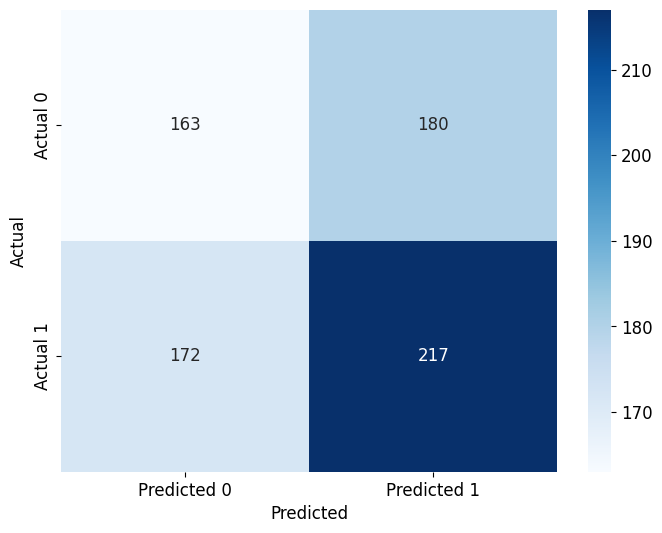

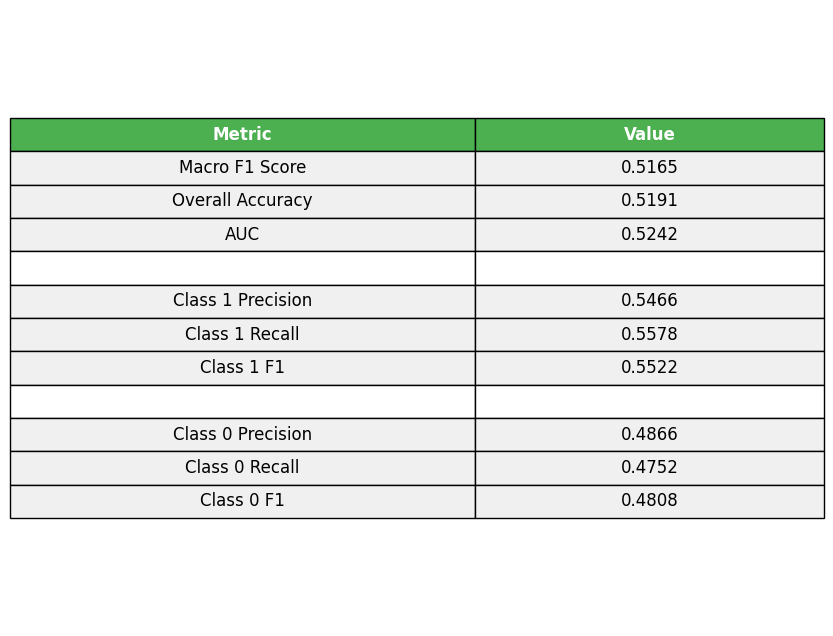


20D_Up Prediction Model - Random Forest Baseline
Starting hyperparameter tuning for 20D model...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters for 20D model: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation F1 score: 0.6228

20D Model Test Set Results:


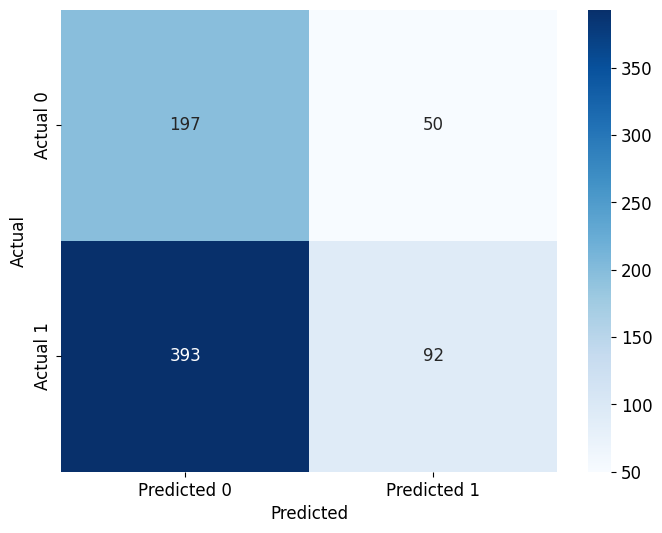

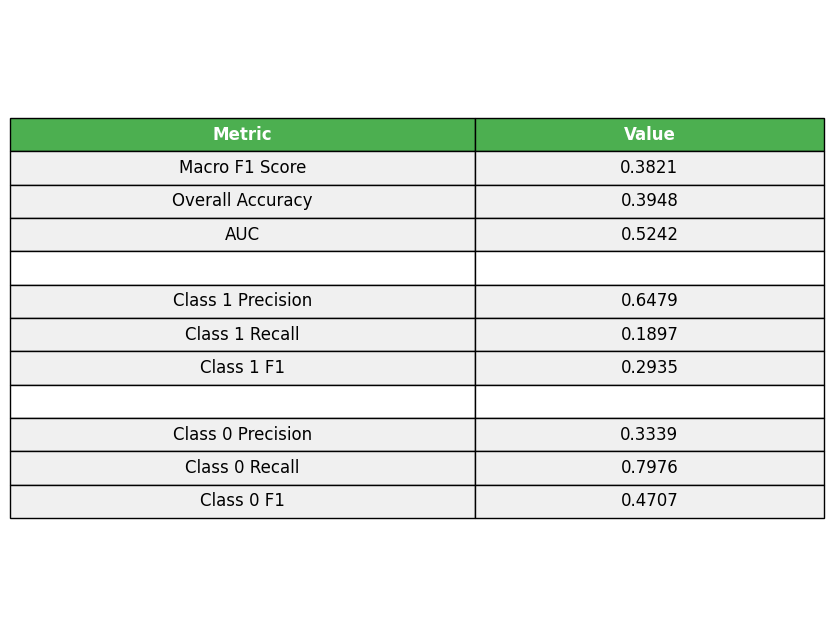


SHAP Feature Importance Analysis
Creating SHAP explainers...
Calculating SHAP values for 1D model...


100%|===================| 1457/1464 [02:47<00:00]        

Calculating SHAP values for 20D model...


 98%|===================| 1441/1464 [00:38<00:00]        


1D_Up Model SHAP Analysis


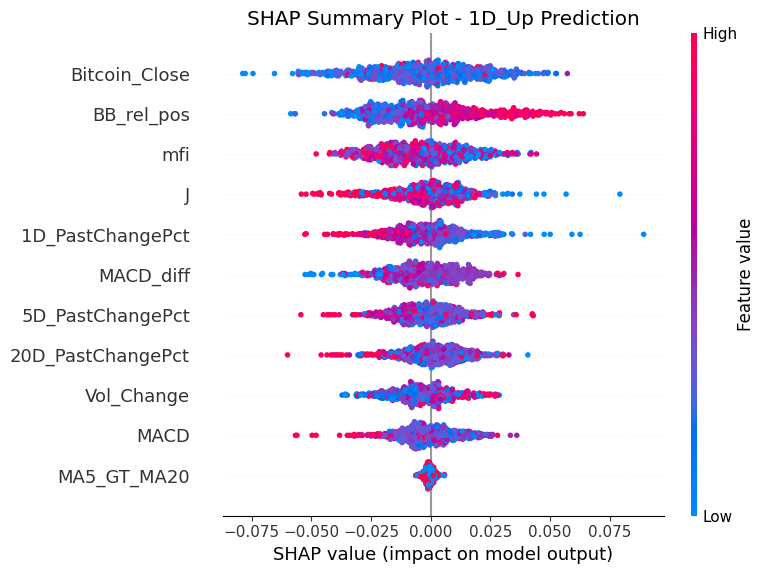

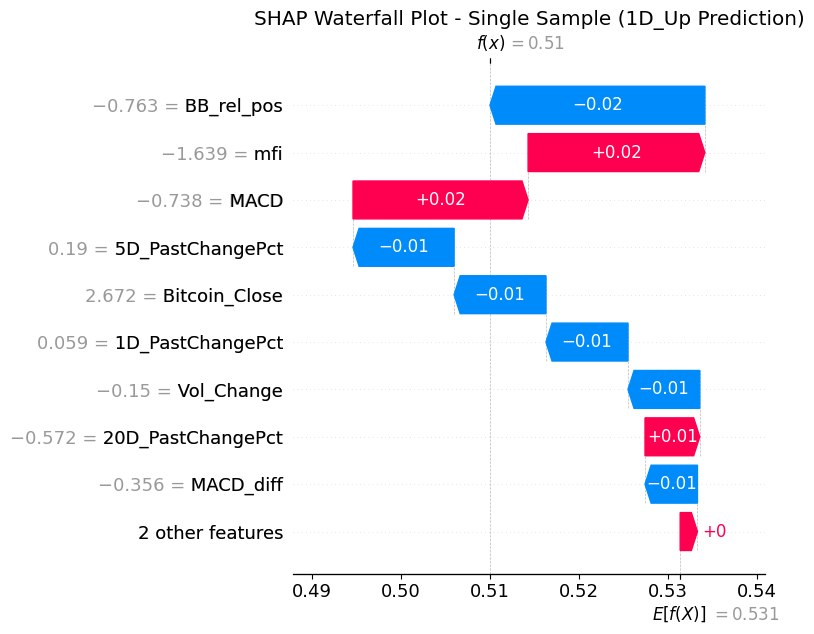


Feature Importance Ranking for 1D_Up Prediction (sorted by absolute value, preserving direction):
Rank Feature              Mean SHAP    |Mean SHAP|  Direction   
---------------------------------------------------------------------------
 1. Bitcoin_Close        -0.002879    0.017661 ↓ Negative
 2. BB_rel_pos           -0.001022    0.017460 ↓ Negative
 3. mfi                  -0.004616    0.014131 ↓ Negative
 4. J                    -0.001890    0.011492 ↓ Negative
 5. 1D_PastChangePct     -0.001964    0.011125 ↓ Negative
 6. MACD_diff            -0.002905    0.011032 ↓ Negative
 7. 5D_PastChangePct     -0.001659    0.009795 ↓ Negative
 8. 20D_PastChangePct    +0.000841    0.009651 ↑ Positive
 9. Vol_Change           -0.003404    0.009304 ↓ Negative
10. MACD                 -0.001702    0.009176 ↓ Negative
11. MA5_GT_MA20          -0.000682    0.001465 ↓ Negative

20D_Up Model SHAP Analysis


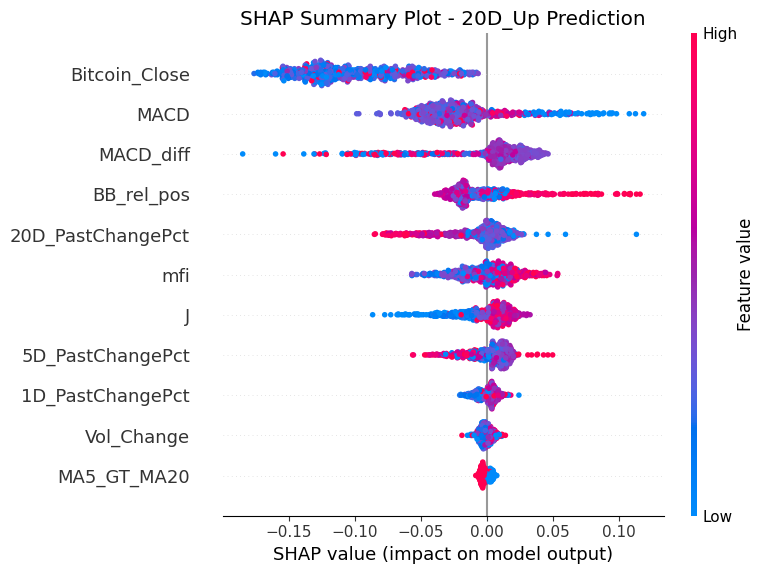

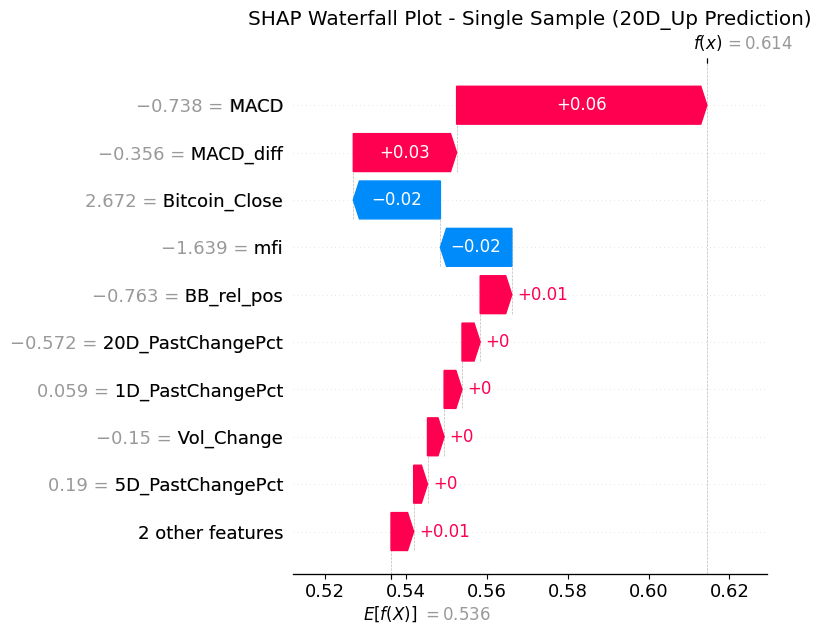


Feature Importance Ranking for 20D_Up Prediction (sorted by absolute value, preserving direction):
Rank Feature              Mean SHAP    |Mean SHAP|  Direction   
---------------------------------------------------------------------------
 1. Bitcoin_Close        -0.098160    0.098160 ↓ Negative
 2. MACD                 -0.017469    0.032434 ↓ Negative
 3. MACD_diff            -0.001803    0.027812 ↓ Negative
 4. BB_rel_pos           -0.001647    0.019793 ↓ Negative
 5. 20D_PastChangePct    -0.006858    0.016756 ↓ Negative
 6. mfi                  +0.001493    0.015555 ↑ Positive
 7. J                    -0.000939    0.014522 ↓ Negative
 8. 5D_PastChangePct     +0.002869    0.012061 ↑ Positive
 9. 1D_PastChangePct     +0.000418    0.005505 ↑ Positive
10. Vol_Change           -0.000461    0.003463 ↓ Negative
11. MA5_GT_MA20          -0.000866    0.002983 ↓ Negative


In [20]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import shap
warnings.filterwarnings('ignore')

plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (12, 8)

# Load data
df = pd.read_csv('DATA.csv')

# Define feature columns 
continuous_features = ['1D_PastChangePct', '5D_PastChangePct', '20D_PastChangePct', 'J', 
                      'mfi', 'MACD', 'MACD_diff',  'BB_rel_pos', 'Vol_Change',"Bitcoin_Close"]
binary_features = ['MA5_GT_MA20']
features = continuous_features + binary_features

# Split data by company in chronological order
train_data_list = []
val_data_list = []
test_data_list = []

for company in df['Company'].unique():
    company_data = df[df['Company'] == company].copy()
    company_data = company_data.sort_values('Date')  # Ensure chronological order
    
    n_company = len(company_data)
    train_size = int(0.7 * n_company)
    val_size = int(0.15 * n_company)
    
    train_data_list.append(company_data.iloc[:train_size])
    val_data_list.append(company_data.iloc[train_size:train_size+val_size])
    test_data_list.append(company_data.iloc[train_size+val_size:])

# Concatenate all companies' data
train_data = pd.concat(train_data_list, ignore_index=True)
val_data = pd.concat(val_data_list, ignore_index=True)
test_data = pd.concat(test_data_list, ignore_index=True)

print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")
print(f"Training set company distribution:\n{train_data['Company'].value_counts().sort_index()}")
print(f"Test set company distribution:\n{test_data['Company'].value_counts().sort_index()}")

# Modified preprocessing function
def preprocess_data(train_df, val_df, test_df, target_col, continuous_features, binary_features):
    all_features = continuous_features + binary_features
    
    # Drop missing values
    train_df = train_df.dropna(subset=all_features + [target_col])
    val_df = val_df.dropna(subset=all_features + [target_col])
    test_df = test_df.dropna(subset=all_features + [target_col])
    
    # Separate continuous and binary features
    X_train_continuous = train_df[continuous_features]
    X_val_continuous = val_df[continuous_features]
    X_test_continuous = test_df[continuous_features]
    
    X_train_binary = train_df[binary_features]
    X_val_binary = val_df[binary_features]
    X_test_binary = test_df[binary_features]
    
    y_train = train_df[target_col]
    y_val = val_df[target_col]
    y_test = test_df[target_col]
    
    # Standardize only continuous features
    scaler = StandardScaler()
    X_train_continuous_scaled = scaler.fit_transform(X_train_continuous)
    X_val_continuous_scaled = scaler.transform(X_val_continuous)
    X_test_continuous_scaled = scaler.transform(X_test_continuous)
    
    # Combine scaled continuous features with unscaled binary features
    X_train_scaled = np.hstack([X_train_continuous_scaled, X_train_binary.values])
    X_val_scaled = np.hstack([X_val_continuous_scaled, X_val_binary.values])
    X_test_scaled = np.hstack([X_test_continuous_scaled, X_test_binary.values])
    
    return X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test, scaler

# Evaluation function
def evaluate_model(y_true, y_pred, y_prob, model_name):
    cm = confusion_matrix(y_true, y_pred)
    
    # Overall metrics
    f1_macro = f1_score(y_true, y_pred, average='macro')
    accuracy = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    
    # Class-specific metrics
    precision_per_class = precision_score(y_true, y_pred, average=None)
    recall_per_class = recall_score(y_true, y_pred, average=None)
    f1_per_class = f1_score(y_true, y_pred, average=None)
    
    # Confusion matrix heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    # Performance metrics table
    plt.figure(figsize=(10, 8))
    plt.axis('tight')
    plt.axis('off')
    
    table_data = [
        ['Metric', 'Value'],
        ['Macro F1 Score', f'{f1_macro:.4f}'],
        ['Overall Accuracy', f'{accuracy:.4f}'],
        ['AUC', f'{auc:.4f}'],
        ['', ''],  # Empty row for separation
        ['Class 1 Precision', f'{precision_per_class[1]:.4f}'],
        ['Class 1 Recall', f'{recall_per_class[1]:.4f}'],
        ['Class 1 F1', f'{f1_per_class[1]:.4f}'],
        ['', ''],  # Empty row for separation
        ['Class 0 Precision', f'{precision_per_class[0]:.4f}'],
        ['Class 0 Recall', f'{recall_per_class[0]:.4f}'],
        ['Class 0 F1', f'{f1_per_class[0]:.4f}']
    ]
    
    table = plt.table(cellText=table_data[1:], colLabels=table_data[0],
                     cellLoc='center', loc='center',
                     colWidths=[0.4, 0.3])
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.5, 2)
    
    # Set table style
    for i in range(len(table_data)):
        for j in range(len(table_data[0])):
            cell = table[(i, j)]
            if i == 0:  # header
                cell.set_facecolor('#4CAF50')
                cell.set_text_props(weight='bold', color='white')
            elif len(table_data[i]) > 0 and table_data[i][0] == '':  # empty rows
                cell.set_facecolor('#ffffff')
                cell.set_text_props(color='white')
            else:
                cell.set_facecolor('#f0f0f0')
    
    plt.show()
    
    return {'confusion_matrix': cm, 'f1_macro': f1_macro, 'accuracy': accuracy, 'auc': auc,
            'class_0_precision': precision_per_class[0], 'class_0_recall': recall_per_class[0], 'class_0_f1': f1_per_class[0],
            'class_1_precision': precision_per_class[1], 'class_1_recall': recall_per_class[1], 'class_1_f1': f1_per_class[1]}

# 1D_Up prediction
print("=" * 60)
print("1D_Up Prediction Model - Random Forest Baseline")
print("=" * 60)

X_train_1d, y_train_1d, X_val_1d, y_val_1d, X_test_1d, y_test_1d, scaler_1d = preprocess_data(
    train_data, val_data, test_data, '1D_Up', continuous_features, binary_features)


tscv = TimeSeriesSplit(n_splits=5)
param_grid = {
    'n_estimators': [300, 400, 500], 
    'max_depth': [ 6, 8,10, None],    
    'min_samples_split': [2, 5, 8], 
    'min_samples_leaf': [1, 2, 3],  
    'max_features': ['sqrt', 'log2'] 
}

print("Starting hyperparameter tuning for 1D model...")
grid_search_1d = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1,class_weight='balanced'),
    param_grid, cv=tscv, scoring='f1', n_jobs=-1, verbose=1
)

grid_search_1d.fit(X_train_1d, y_train_1d)
best_params_1d = grid_search_1d.best_params_
print(f"Best parameters for 1D model: {best_params_1d}")
print(f"Best cross-validation F1 score: {grid_search_1d.best_score_:.4f}")

# Train final model with best parameters
final_model_1d = RandomForestClassifier(**best_params_1d, random_state=42, n_jobs=-1,class_weight='balanced')
final_model_1d.fit(X_train_1d, y_train_1d)

# Evaluate on test set
y_pred_1d = final_model_1d.predict(X_test_1d)
y_prob_1d = final_model_1d.predict_proba(X_test_1d)[:, 1]

print("\n1D Model Test Set Results:")
results_1d = evaluate_model(y_test_1d, y_pred_1d, y_prob_1d, "1D_Up Prediction")

# 20D_Up prediction
print("\n" + "=" * 60)
print("20D_Up Prediction Model - Random Forest Baseline")
print("=" * 60)

X_train_20d, y_train_20d, X_val_20d, y_val_20d, X_test_20d, y_test_20d, scaler_20d = preprocess_data(
    train_data, val_data, test_data, '20D_Up', continuous_features, binary_features)

print("Starting hyperparameter tuning for 20D model...")
grid_search_20d = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1,class_weight='balanced'),
    param_grid, cv=tscv, scoring='f1', n_jobs=-1, verbose=1
)

grid_search_20d.fit(X_train_20d, y_train_20d)
best_params_20d = grid_search_20d.best_params_
print(f"Best parameters for 20D model: {best_params_20d}")
print(f"Best cross-validation F1 score: {grid_search_20d.best_score_:.4f}")

# Train final model with best parameters
final_model_20d = RandomForestClassifier(**best_params_20d, random_state=42, n_jobs=-1,class_weight='balanced')
final_model_20d.fit(X_train_20d, y_train_20d)

# Evaluate on test set
y_pred_20d = final_model_20d.predict(X_test_20d)
y_prob_20d = final_model_20d.predict_proba(X_test_20d)[:, 1]

print("\n20D Model Test Set Results:")
results_20d = evaluate_model(y_test_20d, y_pred_20d, y_prob_20d, "20D_Up Prediction")

# SHAP Feature Importance Analysis
print("\n" + "=" * 60)
print("SHAP Feature Importance Analysis")
print("=" * 60)

# Get feature names
feature_names = continuous_features + binary_features
feature_names_array = np.array(feature_names)

# Create SHAP explainers for both models
print("Creating SHAP explainers...")
explainer_1d = shap.Explainer(final_model_1d, X_train_1d)
explainer_20d = shap.Explainer(final_model_20d, X_train_20d)

# Calculate SHAP values for test sets
print("Calculating SHAP values for 1D model...")
shap_values_1d = explainer_1d(X_test_1d,check_additivity=False)

print("Calculating SHAP values for 20D model...")
shap_values_20d = explainer_20d(X_test_20d,check_additivity=False)

# 1D Model SHAP Analysis
print("\n" + "=" * 40)
print("1D_Up Model SHAP Analysis")
print("=" * 40)

# Summary plot for 1D model - use only positive class SHAP values
if len(shap_values_1d.values.shape) == 3:
    # Multi-class case - use positive class (class 1)
    shap_vals_1d = shap_values_1d.values[:, :, 1]
else:
    # Binary case - use all values
    shap_vals_1d = shap_values_1d.values

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_vals_1d, X_test_1d, feature_names=feature_names_array, show=False)
plt.title('SHAP Summary Plot - 1D_Up Prediction')
plt.tight_layout()
plt.show()

# Waterfall plot for a single sample (1D model)
plt.figure(figsize=(10, 6))
if len(shap_values_1d.values.shape) == 3:
    # For multi-class, create a new Explanation object for single class
    sample_explanation = shap.Explanation(
        values=shap_values_1d.values[0, :, 1],
        base_values=shap_values_1d.base_values[0, 1] if hasattr(shap_values_1d.base_values, 'shape') and len(shap_values_1d.base_values.shape) > 1 else shap_values_1d.base_values[0],
        data=shap_values_1d.data[0],
        feature_names=feature_names_array
    )
else:
    sample_explanation = shap_values_1d[0]

shap.waterfall_plot(sample_explanation, show=False)
plt.title('SHAP Waterfall Plot - Single Sample (1D_Up Prediction)')
plt.tight_layout()
plt.show()

# Feature importance ranking table for 1D model
if len(shap_values_1d.values.shape) == 3:
    mean_shap_1d = np.mean(shap_values_1d.values[:, :, 1], axis=0)
    abs_mean_shap_1d = np.mean(np.abs(shap_values_1d.values[:, :, 1]), axis=0)
else:
    mean_shap_1d = np.mean(shap_values_1d.values, axis=0)
    abs_mean_shap_1d = np.mean(np.abs(shap_values_1d.values), axis=0)

importance_df_1d = pd.DataFrame({
    'Feature': feature_names,
    'Mean_SHAP': mean_shap_1d,
    'Abs_Mean_SHAP': abs_mean_shap_1d
}).sort_values('Abs_Mean_SHAP', ascending=False)

print("\nFeature Importance Ranking for 1D_Up Prediction (sorted by absolute value, preserving direction):")
print("=" * 75)
print(f"{'Rank':<4} {'Feature':<20} {'Mean SHAP':<12} {'|Mean SHAP|':<12} {'Direction':<12}")
print("-" * 75)

for i, (_, row) in enumerate(importance_df_1d.iterrows(), 1):
    direction = "↑ Positive" if row['Mean_SHAP'] > 0 else "↓ Negative"
    print(f"{i:>2}. {row['Feature']:<20} {row['Mean_SHAP']:>+9.6f} {row['Abs_Mean_SHAP']:>11.6f} {direction}")

# 20D Model SHAP Analysis
print("\n" + "=" * 40)
print("20D_Up Model SHAP Analysis")
print("=" * 40)

# Summary plot for 20D model - use only positive class SHAP values
if len(shap_values_20d.values.shape) == 3:
    # Multi-class case - use positive class (class 1)
    shap_vals_20d = shap_values_20d.values[:, :, 1]
else:
    # Binary case - use all values
    shap_vals_20d = shap_values_20d.values

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_vals_20d, X_test_20d, feature_names=feature_names_array, show=False)
plt.title('SHAP Summary Plot - 20D_Up Prediction')
plt.tight_layout()
plt.show()

# Waterfall plot for a single sample (20D model)
plt.figure(figsize=(10, 6))
if len(shap_values_20d.values.shape) == 3:
    # For multi-class, create a new Explanation object for single class
    sample_explanation = shap.Explanation(
        values=shap_values_20d.values[0, :, 1],
        base_values=shap_values_20d.base_values[0, 1] if hasattr(shap_values_20d.base_values, 'shape') and len(shap_values_20d.base_values.shape) > 1 else shap_values_20d.base_values[0],
        data=shap_values_20d.data[0],
        feature_names=feature_names_array
    )
else:
    sample_explanation = shap_values_20d[0]

shap.waterfall_plot(sample_explanation, show=False)
plt.title('SHAP Waterfall Plot - Single Sample (20D_Up Prediction)')
plt.tight_layout()
plt.show()

# Feature importance ranking table for 20D model
if len(shap_values_20d.values.shape) == 3:
    mean_shap_20d = np.mean(shap_values_20d.values[:, :, 1], axis=0)
    abs_mean_shap_20d = np.mean(np.abs(shap_values_20d.values[:, :, 1]), axis=0)
else:
    mean_shap_20d = np.mean(shap_values_20d.values, axis=0)
    abs_mean_shap_20d = np.mean(np.abs(shap_values_20d.values), axis=0)

importance_df_20d = pd.DataFrame({
    'Feature': feature_names,
    'Mean_SHAP': mean_shap_20d,
    'Abs_Mean_SHAP': abs_mean_shap_20d
}).sort_values('Abs_Mean_SHAP', ascending=False)

print("\nFeature Importance Ranking for 20D_Up Prediction (sorted by absolute value, preserving direction):")
print("=" * 75)
print(f"{'Rank':<4} {'Feature':<20} {'Mean SHAP':<12} {'|Mean SHAP|':<12} {'Direction':<12}")
print("-" * 75)

for i, (_, row) in enumerate(importance_df_20d.iterrows(), 1):
    direction = "↑ Positive" if row['Mean_SHAP'] > 0 else "↓ Negative"
    print(f"{i:>2}. {row['Feature']:<20} {row['Mean_SHAP']:>+9.6f} {row['Abs_Mean_SHAP']:>11.6f} {direction}")

## Gold

Training set size: 3404
Validation set size: 728
Test set size: 732
Training set company distribution:
Company
Alibaba    851
Apple      851
Philips    851
Tesla      851
Name: count, dtype: int64
Test set company distribution:
Company
Alibaba    183
Apple      183
Philips    183
Tesla      183
Name: count, dtype: int64
1D_Up Prediction Model - Random Forest Baseline
Starting hyperparameter tuning for 1D model...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters for 1D model: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Best cross-validation F1 score: 0.5464

1D Model Test Set Results:


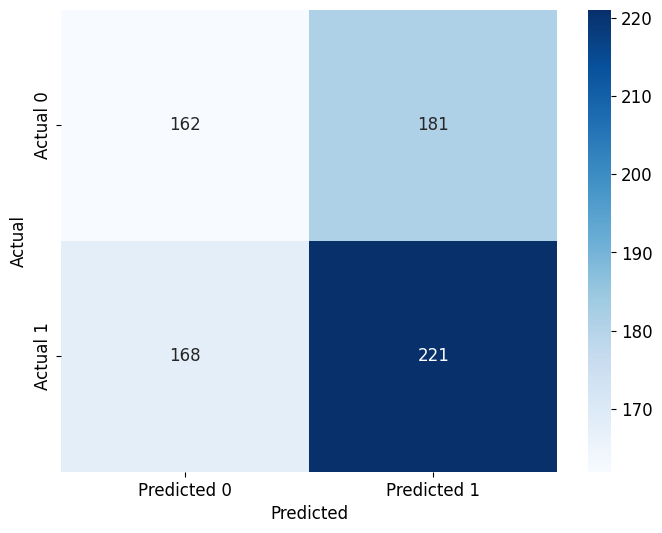

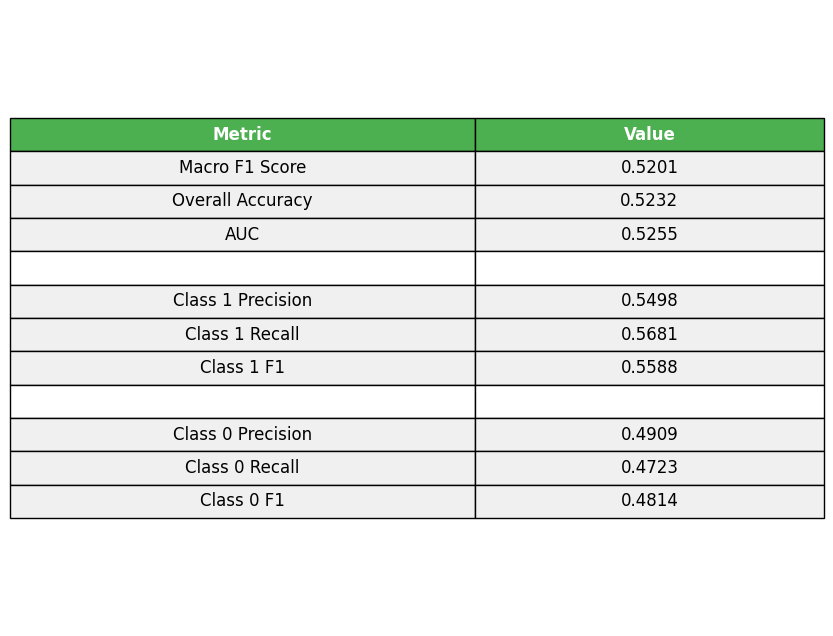


20D_Up Prediction Model - Random Forest Baseline
Starting hyperparameter tuning for 20D model...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters for 20D model: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation F1 score: 0.6243

20D Model Test Set Results:


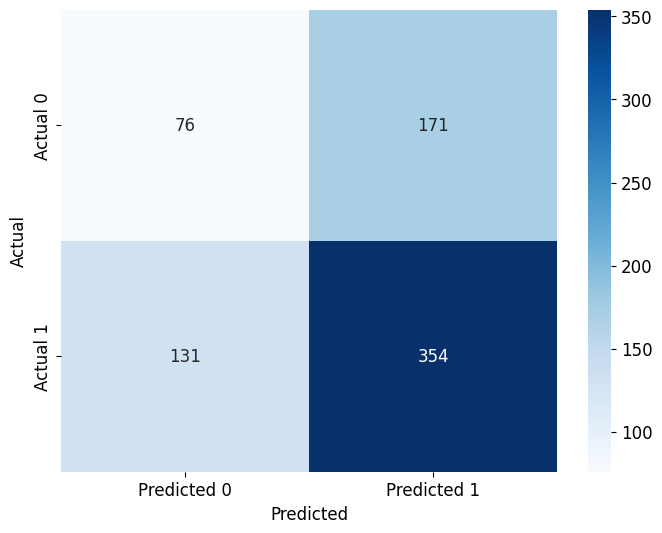

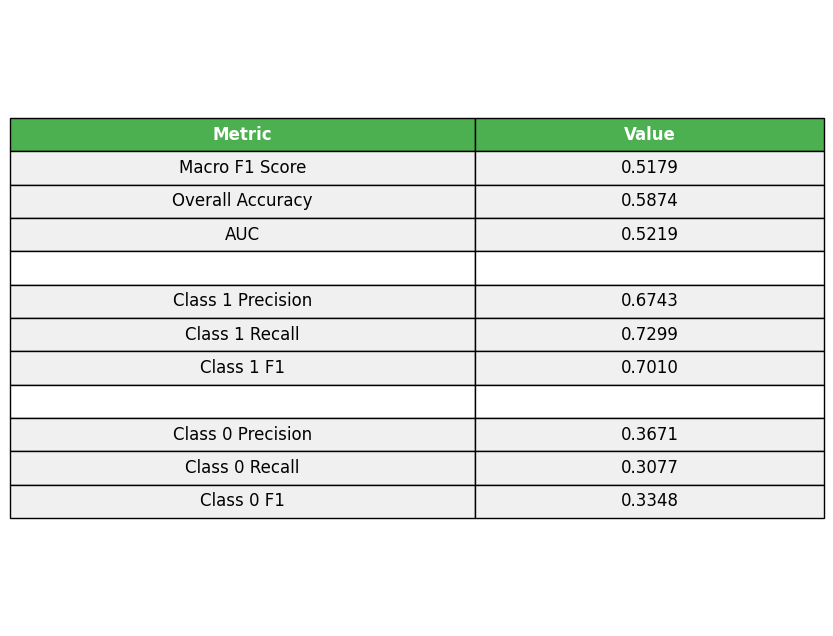


SHAP Feature Importance Analysis
Creating SHAP explainers...
Calculating SHAP values for 1D model...


100%|===================| 1462/1464 [02:50<00:00]        

Calculating SHAP values for 20D model...


 99%|===================| 1456/1464 [01:36<00:00]        


1D_Up Model SHAP Analysis


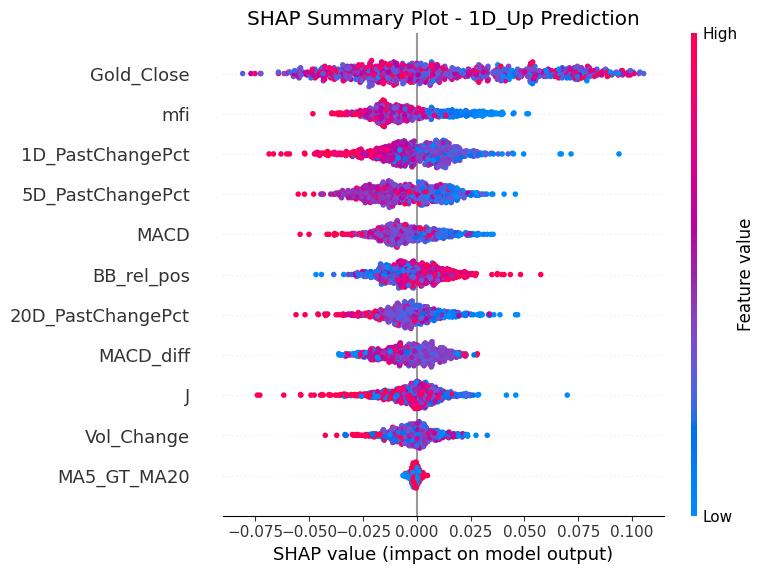

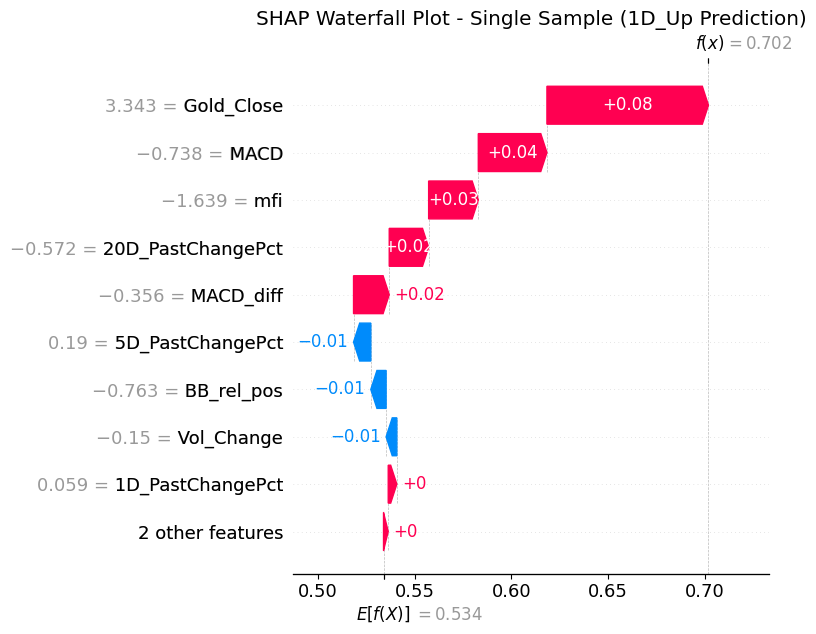


Feature Importance Ranking for 1D_Up Prediction (sorted by absolute value, preserving direction):
Rank Feature              Mean SHAP    |Mean SHAP|  Direction   
---------------------------------------------------------------------------
 1. Gold_Close           +0.012785    0.035347 ↑ Positive
 2. mfi                  -0.003742    0.014590 ↓ Negative
 3. 1D_PastChangePct     -0.001103    0.014181 ↓ Negative
 4. 5D_PastChangePct     -0.005002    0.014091 ↓ Negative
 5. MACD                 -0.004374    0.010924 ↓ Negative
 6. BB_rel_pos           -0.001602    0.010216 ↓ Negative
 7. 20D_PastChangePct    -0.003046    0.010163 ↓ Negative
 8. MACD_diff            -0.002992    0.009915 ↓ Negative
 9. J                    -0.002370    0.009610 ↓ Negative
10. Vol_Change           -0.001958    0.007515 ↓ Negative
11. MA5_GT_MA20          -0.000812    0.001505 ↓ Negative

20D_Up Model SHAP Analysis


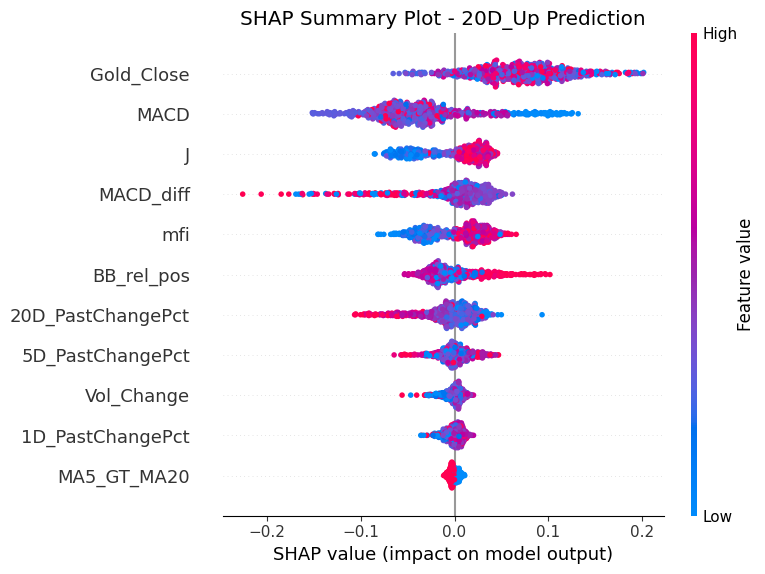

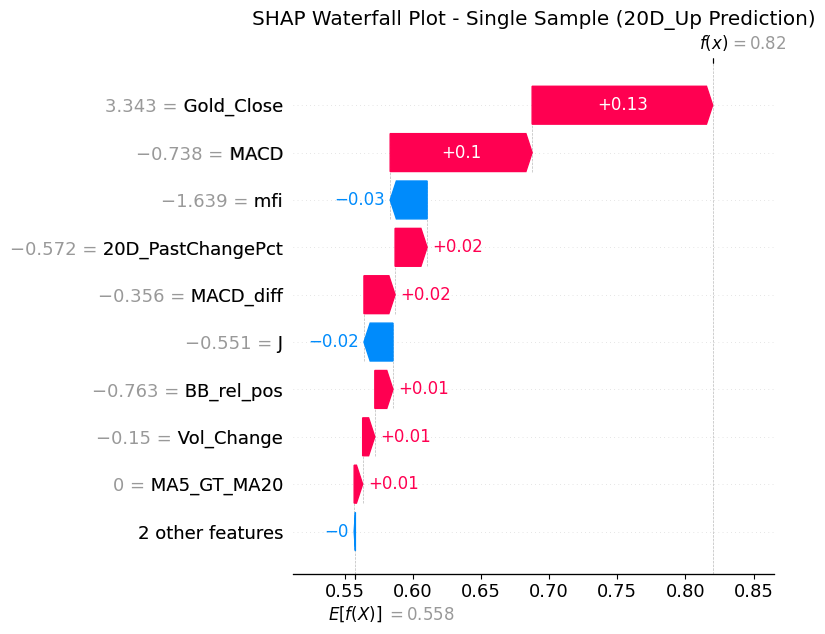


Feature Importance Ranking for 20D_Up Prediction (sorted by absolute value, preserving direction):
Rank Feature              Mean SHAP    |Mean SHAP|  Direction   
---------------------------------------------------------------------------
 1. Gold_Close           +0.070505    0.073736 ↑ Positive
 2. MACD                 -0.034390    0.054115 ↓ Negative
 3. J                    -0.003068    0.029823 ↓ Negative
 4. MACD_diff            -0.001356    0.029123 ↓ Negative
 5. mfi                  +0.000306    0.026946 ↑ Positive
 6. BB_rel_pos           -0.000697    0.021850 ↓ Negative
 7. 20D_PastChangePct    -0.006578    0.020652 ↓ Negative
 8. 5D_PastChangePct     +0.000712    0.011571 ↑ Positive
 9. Vol_Change           -0.000739    0.006889 ↓ Negative
10. 1D_PastChangePct     -0.000421    0.006528 ↓ Negative
11. MA5_GT_MA20          -0.000857    0.003464 ↓ Negative


In [21]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import shap
warnings.filterwarnings('ignore')

plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (12, 8)

# Load data
df = pd.read_csv('DATA.csv')

# Define feature columns 
continuous_features = ['1D_PastChangePct', '5D_PastChangePct', '20D_PastChangePct', 'J', 
                      'mfi', 'MACD', 'MACD_diff',  'BB_rel_pos', 'Vol_Change',"Gold_Close"]
binary_features = ['MA5_GT_MA20']
features = continuous_features + binary_features

# Split data by company in chronological order
train_data_list = []
val_data_list = []
test_data_list = []

for company in df['Company'].unique():
    company_data = df[df['Company'] == company].copy()
    company_data = company_data.sort_values('Date')  # Ensure chronological order
    
    n_company = len(company_data)
    train_size = int(0.7 * n_company)
    val_size = int(0.15 * n_company)
    
    train_data_list.append(company_data.iloc[:train_size])
    val_data_list.append(company_data.iloc[train_size:train_size+val_size])
    test_data_list.append(company_data.iloc[train_size+val_size:])

# Concatenate all companies' data
train_data = pd.concat(train_data_list, ignore_index=True)
val_data = pd.concat(val_data_list, ignore_index=True)
test_data = pd.concat(test_data_list, ignore_index=True)

print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")
print(f"Training set company distribution:\n{train_data['Company'].value_counts().sort_index()}")
print(f"Test set company distribution:\n{test_data['Company'].value_counts().sort_index()}")

# Modified preprocessing function
def preprocess_data(train_df, val_df, test_df, target_col, continuous_features, binary_features):
    all_features = continuous_features + binary_features
    
    # Drop missing values
    train_df = train_df.dropna(subset=all_features + [target_col])
    val_df = val_df.dropna(subset=all_features + [target_col])
    test_df = test_df.dropna(subset=all_features + [target_col])
    
    # Separate continuous and binary features
    X_train_continuous = train_df[continuous_features]
    X_val_continuous = val_df[continuous_features]
    X_test_continuous = test_df[continuous_features]
    
    X_train_binary = train_df[binary_features]
    X_val_binary = val_df[binary_features]
    X_test_binary = test_df[binary_features]
    
    y_train = train_df[target_col]
    y_val = val_df[target_col]
    y_test = test_df[target_col]
    
    # Standardize only continuous features
    scaler = StandardScaler()
    X_train_continuous_scaled = scaler.fit_transform(X_train_continuous)
    X_val_continuous_scaled = scaler.transform(X_val_continuous)
    X_test_continuous_scaled = scaler.transform(X_test_continuous)
    
    # Combine scaled continuous features with unscaled binary features
    X_train_scaled = np.hstack([X_train_continuous_scaled, X_train_binary.values])
    X_val_scaled = np.hstack([X_val_continuous_scaled, X_val_binary.values])
    X_test_scaled = np.hstack([X_test_continuous_scaled, X_test_binary.values])
    
    return X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test, scaler

# Evaluation function
def evaluate_model(y_true, y_pred, y_prob, model_name):
    cm = confusion_matrix(y_true, y_pred)
    
    # Overall metrics
    f1_macro = f1_score(y_true, y_pred, average='macro')
    accuracy = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    
    # Class-specific metrics
    precision_per_class = precision_score(y_true, y_pred, average=None)
    recall_per_class = recall_score(y_true, y_pred, average=None)
    f1_per_class = f1_score(y_true, y_pred, average=None)
    
    # Confusion matrix heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    # Performance metrics table
    plt.figure(figsize=(10, 8))
    plt.axis('tight')
    plt.axis('off')
    
    table_data = [
        ['Metric', 'Value'],
        ['Macro F1 Score', f'{f1_macro:.4f}'],
        ['Overall Accuracy', f'{accuracy:.4f}'],
        ['AUC', f'{auc:.4f}'],
        ['', ''],  # Empty row for separation
        ['Class 1 Precision', f'{precision_per_class[1]:.4f}'],
        ['Class 1 Recall', f'{recall_per_class[1]:.4f}'],
        ['Class 1 F1', f'{f1_per_class[1]:.4f}'],
        ['', ''],  # Empty row for separation
        ['Class 0 Precision', f'{precision_per_class[0]:.4f}'],
        ['Class 0 Recall', f'{recall_per_class[0]:.4f}'],
        ['Class 0 F1', f'{f1_per_class[0]:.4f}']
    ]
    
    table = plt.table(cellText=table_data[1:], colLabels=table_data[0],
                     cellLoc='center', loc='center',
                     colWidths=[0.4, 0.3])
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.5, 2)
    
    # Set table style
    for i in range(len(table_data)):
        for j in range(len(table_data[0])):
            cell = table[(i, j)]
            if i == 0:  # header
                cell.set_facecolor('#4CAF50')
                cell.set_text_props(weight='bold', color='white')
            elif len(table_data[i]) > 0 and table_data[i][0] == '':  # empty rows
                cell.set_facecolor('#ffffff')
                cell.set_text_props(color='white')
            else:
                cell.set_facecolor('#f0f0f0')
    
    plt.show()
    
    return {'confusion_matrix': cm, 'f1_macro': f1_macro, 'accuracy': accuracy, 'auc': auc,
            'class_0_precision': precision_per_class[0], 'class_0_recall': recall_per_class[0], 'class_0_f1': f1_per_class[0],
            'class_1_precision': precision_per_class[1], 'class_1_recall': recall_per_class[1], 'class_1_f1': f1_per_class[1]}

# 1D_Up prediction
print("=" * 60)
print("1D_Up Prediction Model - Random Forest Baseline")
print("=" * 60)

X_train_1d, y_train_1d, X_val_1d, y_val_1d, X_test_1d, y_test_1d, scaler_1d = preprocess_data(
    train_data, val_data, test_data, '1D_Up', continuous_features, binary_features)


tscv = TimeSeriesSplit(n_splits=5)
param_grid = {
    'n_estimators': [300, 400, 500], 
    'max_depth': [ 6, 8,10, None],    
    'min_samples_split': [2, 5, 8], 
    'min_samples_leaf': [1, 2, 3],  
    'max_features': ['sqrt', 'log2'] 
}

print("Starting hyperparameter tuning for 1D model...")
grid_search_1d = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1,class_weight='balanced'),
    param_grid, cv=tscv, scoring='f1', n_jobs=-1, verbose=1
)

grid_search_1d.fit(X_train_1d, y_train_1d)
best_params_1d = grid_search_1d.best_params_
print(f"Best parameters for 1D model: {best_params_1d}")
print(f"Best cross-validation F1 score: {grid_search_1d.best_score_:.4f}")

# Train final model with best parameters
final_model_1d = RandomForestClassifier(**best_params_1d, random_state=42, n_jobs=-1,class_weight='balanced')
final_model_1d.fit(X_train_1d, y_train_1d)

# Evaluate on test set
y_pred_1d = final_model_1d.predict(X_test_1d)
y_prob_1d = final_model_1d.predict_proba(X_test_1d)[:, 1]

print("\n1D Model Test Set Results:")
results_1d = evaluate_model(y_test_1d, y_pred_1d, y_prob_1d, "1D_Up Prediction")

# 20D_Up prediction
print("\n" + "=" * 60)
print("20D_Up Prediction Model - Random Forest Baseline")
print("=" * 60)

X_train_20d, y_train_20d, X_val_20d, y_val_20d, X_test_20d, y_test_20d, scaler_20d = preprocess_data(
    train_data, val_data, test_data, '20D_Up', continuous_features, binary_features)

print("Starting hyperparameter tuning for 20D model...")
grid_search_20d = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1,class_weight='balanced'),
    param_grid, cv=tscv, scoring='f1', n_jobs=-1, verbose=1
)

grid_search_20d.fit(X_train_20d, y_train_20d)
best_params_20d = grid_search_20d.best_params_
print(f"Best parameters for 20D model: {best_params_20d}")
print(f"Best cross-validation F1 score: {grid_search_20d.best_score_:.4f}")

# Train final model with best parameters
final_model_20d = RandomForestClassifier(**best_params_20d, random_state=42, n_jobs=-1,class_weight='balanced')
final_model_20d.fit(X_train_20d, y_train_20d)

# Evaluate on test set
y_pred_20d = final_model_20d.predict(X_test_20d)
y_prob_20d = final_model_20d.predict_proba(X_test_20d)[:, 1]

print("\n20D Model Test Set Results:")
results_20d = evaluate_model(y_test_20d, y_pred_20d, y_prob_20d, "20D_Up Prediction")

# SHAP Feature Importance Analysis
print("\n" + "=" * 60)
print("SHAP Feature Importance Analysis")
print("=" * 60)

# Get feature names
feature_names = continuous_features + binary_features
feature_names_array = np.array(feature_names)

# Create SHAP explainers for both models
print("Creating SHAP explainers...")
explainer_1d = shap.Explainer(final_model_1d, X_train_1d)
explainer_20d = shap.Explainer(final_model_20d, X_train_20d)

# Calculate SHAP values for test sets
print("Calculating SHAP values for 1D model...")
shap_values_1d = explainer_1d(X_test_1d,check_additivity=False)

print("Calculating SHAP values for 20D model...")
shap_values_20d = explainer_20d(X_test_20d,check_additivity=False)

# 1D Model SHAP Analysis
print("\n" + "=" * 40)
print("1D_Up Model SHAP Analysis")
print("=" * 40)

# Summary plot for 1D model - use only positive class SHAP values
if len(shap_values_1d.values.shape) == 3:
    # Multi-class case - use positive class (class 1)
    shap_vals_1d = shap_values_1d.values[:, :, 1]
else:
    # Binary case - use all values
    shap_vals_1d = shap_values_1d.values

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_vals_1d, X_test_1d, feature_names=feature_names_array, show=False)
plt.title('SHAP Summary Plot - 1D_Up Prediction')
plt.tight_layout()
plt.show()

# Waterfall plot for a single sample (1D model)
plt.figure(figsize=(10, 6))
if len(shap_values_1d.values.shape) == 3:
    # For multi-class, create a new Explanation object for single class
    sample_explanation = shap.Explanation(
        values=shap_values_1d.values[0, :, 1],
        base_values=shap_values_1d.base_values[0, 1] if hasattr(shap_values_1d.base_values, 'shape') and len(shap_values_1d.base_values.shape) > 1 else shap_values_1d.base_values[0],
        data=shap_values_1d.data[0],
        feature_names=feature_names_array
    )
else:
    sample_explanation = shap_values_1d[0]

shap.waterfall_plot(sample_explanation, show=False)
plt.title('SHAP Waterfall Plot - Single Sample (1D_Up Prediction)')
plt.tight_layout()
plt.show()

# Feature importance ranking table for 1D model
if len(shap_values_1d.values.shape) == 3:
    mean_shap_1d = np.mean(shap_values_1d.values[:, :, 1], axis=0)
    abs_mean_shap_1d = np.mean(np.abs(shap_values_1d.values[:, :, 1]), axis=0)
else:
    mean_shap_1d = np.mean(shap_values_1d.values, axis=0)
    abs_mean_shap_1d = np.mean(np.abs(shap_values_1d.values), axis=0)

importance_df_1d = pd.DataFrame({
    'Feature': feature_names,
    'Mean_SHAP': mean_shap_1d,
    'Abs_Mean_SHAP': abs_mean_shap_1d
}).sort_values('Abs_Mean_SHAP', ascending=False)

print("\nFeature Importance Ranking for 1D_Up Prediction (sorted by absolute value, preserving direction):")
print("=" * 75)
print(f"{'Rank':<4} {'Feature':<20} {'Mean SHAP':<12} {'|Mean SHAP|':<12} {'Direction':<12}")
print("-" * 75)

for i, (_, row) in enumerate(importance_df_1d.iterrows(), 1):
    direction = "↑ Positive" if row['Mean_SHAP'] > 0 else "↓ Negative"
    print(f"{i:>2}. {row['Feature']:<20} {row['Mean_SHAP']:>+9.6f} {row['Abs_Mean_SHAP']:>11.6f} {direction}")

# 20D Model SHAP Analysis
print("\n" + "=" * 40)
print("20D_Up Model SHAP Analysis")
print("=" * 40)

# Summary plot for 20D model - use only positive class SHAP values
if len(shap_values_20d.values.shape) == 3:
    # Multi-class case - use positive class (class 1)
    shap_vals_20d = shap_values_20d.values[:, :, 1]
else:
    # Binary case - use all values
    shap_vals_20d = shap_values_20d.values

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_vals_20d, X_test_20d, feature_names=feature_names_array, show=False)
plt.title('SHAP Summary Plot - 20D_Up Prediction')
plt.tight_layout()
plt.show()

# Waterfall plot for a single sample (20D model)
plt.figure(figsize=(10, 6))
if len(shap_values_20d.values.shape) == 3:
    # For multi-class, create a new Explanation object for single class
    sample_explanation = shap.Explanation(
        values=shap_values_20d.values[0, :, 1],
        base_values=shap_values_20d.base_values[0, 1] if hasattr(shap_values_20d.base_values, 'shape') and len(shap_values_20d.base_values.shape) > 1 else shap_values_20d.base_values[0],
        data=shap_values_20d.data[0],
        feature_names=feature_names_array
    )
else:
    sample_explanation = shap_values_20d[0]

shap.waterfall_plot(sample_explanation, show=False)
plt.title('SHAP Waterfall Plot - Single Sample (20D_Up Prediction)')
plt.tight_layout()
plt.show()

# Feature importance ranking table for 20D model
if len(shap_values_20d.values.shape) == 3:
    mean_shap_20d = np.mean(shap_values_20d.values[:, :, 1], axis=0)
    abs_mean_shap_20d = np.mean(np.abs(shap_values_20d.values[:, :, 1]), axis=0)
else:
    mean_shap_20d = np.mean(shap_values_20d.values, axis=0)
    abs_mean_shap_20d = np.mean(np.abs(shap_values_20d.values), axis=0)

importance_df_20d = pd.DataFrame({
    'Feature': feature_names,
    'Mean_SHAP': mean_shap_20d,
    'Abs_Mean_SHAP': abs_mean_shap_20d
}).sort_values('Abs_Mean_SHAP', ascending=False)

print("\nFeature Importance Ranking for 20D_Up Prediction (sorted by absolute value, preserving direction):")
print("=" * 75)
print(f"{'Rank':<4} {'Feature':<20} {'Mean SHAP':<12} {'|Mean SHAP|':<12} {'Direction':<12}")
print("-" * 75)

for i, (_, row) in enumerate(importance_df_20d.iterrows(), 1):
    direction = "↑ Positive" if row['Mean_SHAP'] > 0 else "↓ Negative"
    print(f"{i:>2}. {row['Feature']:<20} {row['Mean_SHAP']:>+9.6f} {row['Abs_Mean_SHAP']:>11.6f} {direction}")

Training set size: 3404
Validation set size: 728
Test set size: 732
Training set company distribution:
Company
Alibaba    851
Apple      851
Philips    851
Tesla      851
Name: count, dtype: int64
Test set company distribution:
Company
Alibaba    183
Apple      183
Philips    183
Tesla      183
Name: count, dtype: int64
第一部分：基线模型训练和评估（不含利率特征）
1D_Up Prediction Model - Random Forest Baseline (无利率)
Starting hyperparameter tuning for 1D baseline model...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters for 1D baseline model: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Best cross-validation F1 score: 0.5444

1D Baseline Model Test Set Results:


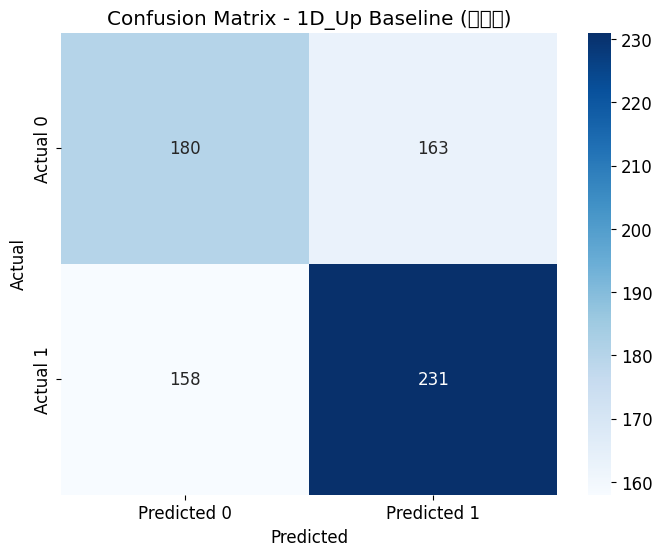

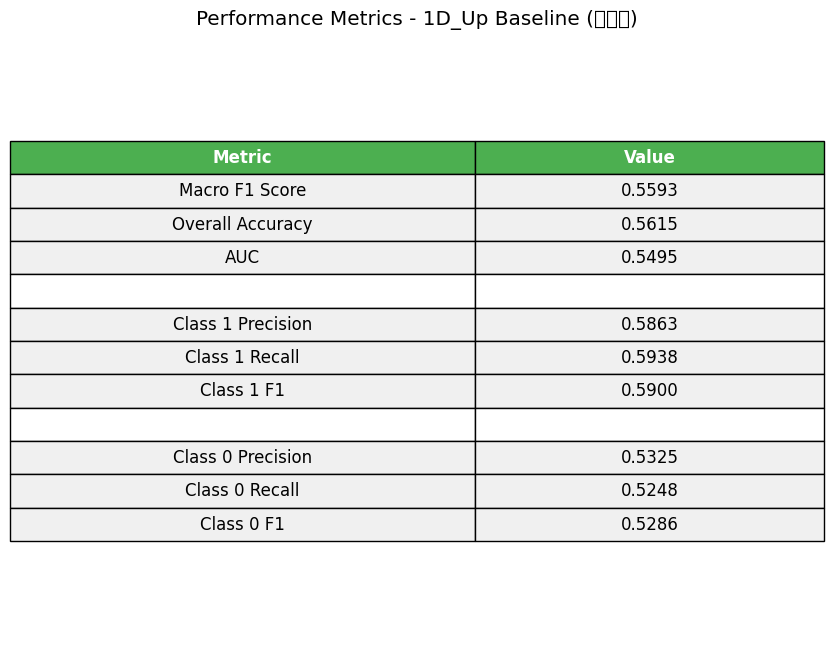


20D_Up Prediction Model - Random Forest Baseline (无利率)
Starting hyperparameter tuning for 20D baseline model...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters for 20D baseline model: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
Best cross-validation F1 score: 0.5863

20D Baseline Model Test Set Results:


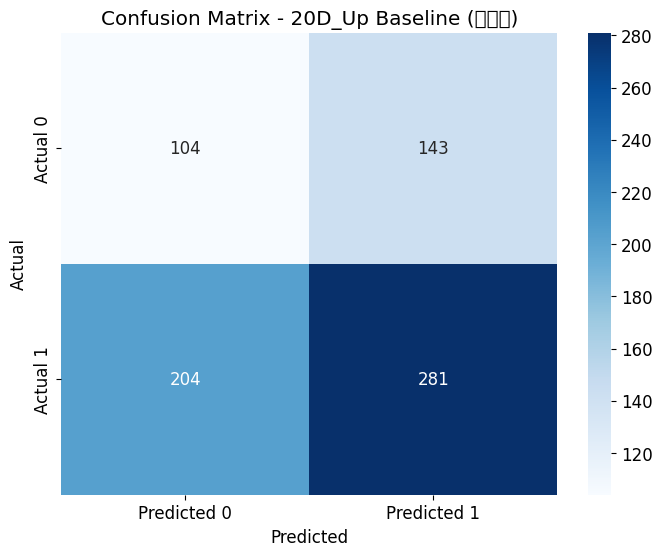

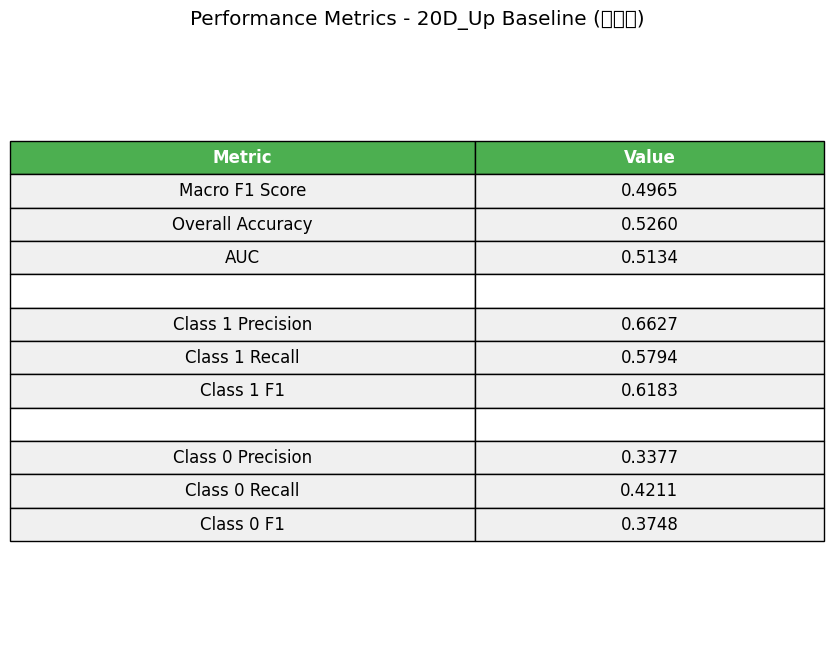


第二部分：改进模型训练和评估（含利率特征）
1D_Up Prediction Model - Random Forest Improved (含利率)
Starting hyperparameter tuning for 1D improved model...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters for 1D improved model: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Best cross-validation F1 score: 0.5399

1D Improved Model Test Set Results:


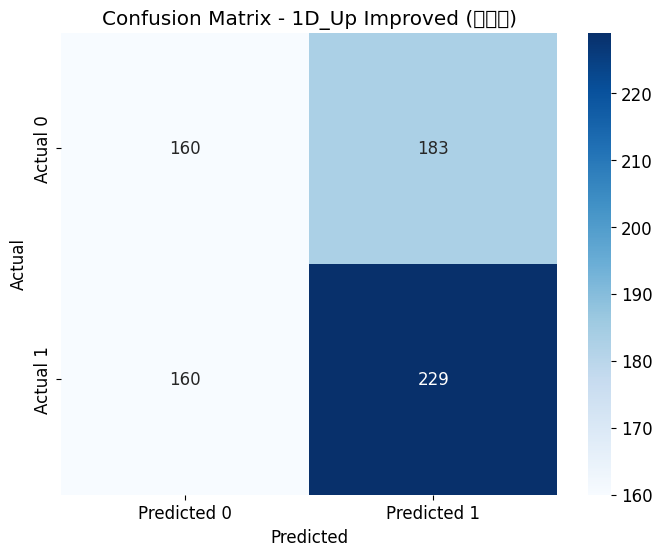

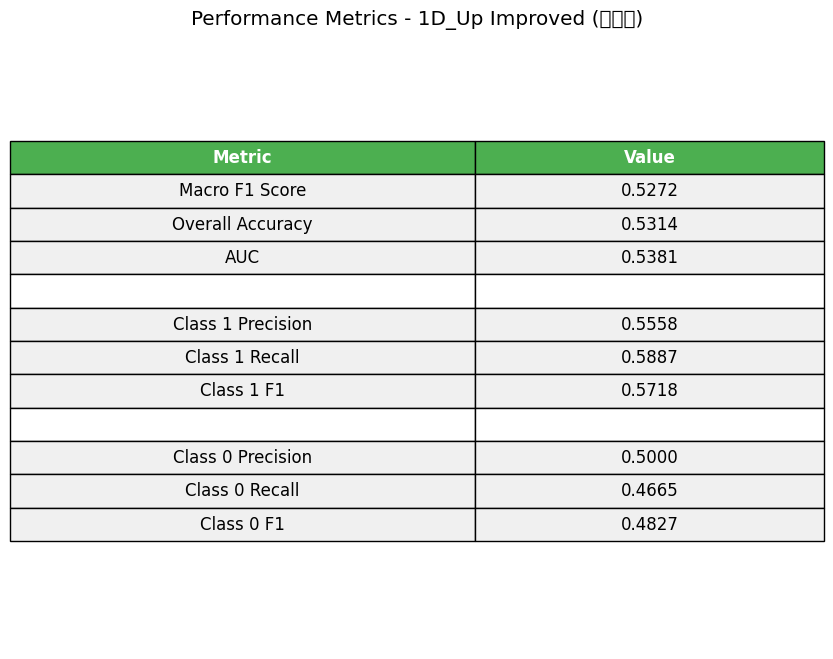


20D_Up Prediction Model - Random Forest Improved (含利率)
Starting hyperparameter tuning for 20D improved model...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters for 20D improved model: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Best cross-validation F1 score: 0.6045

20D Improved Model Test Set Results:


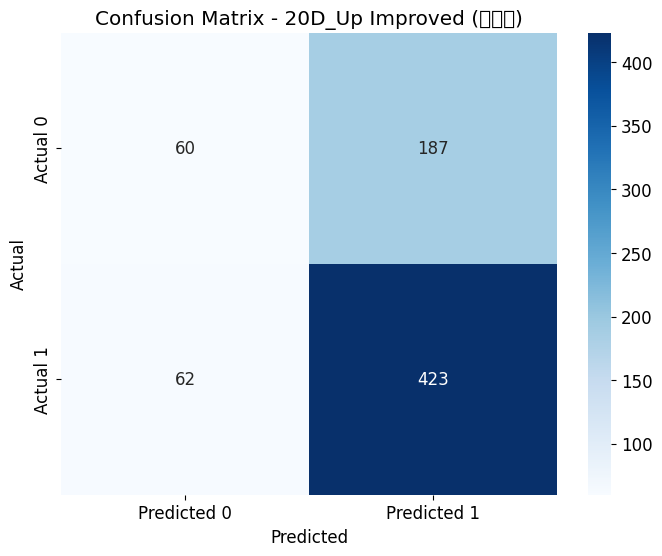

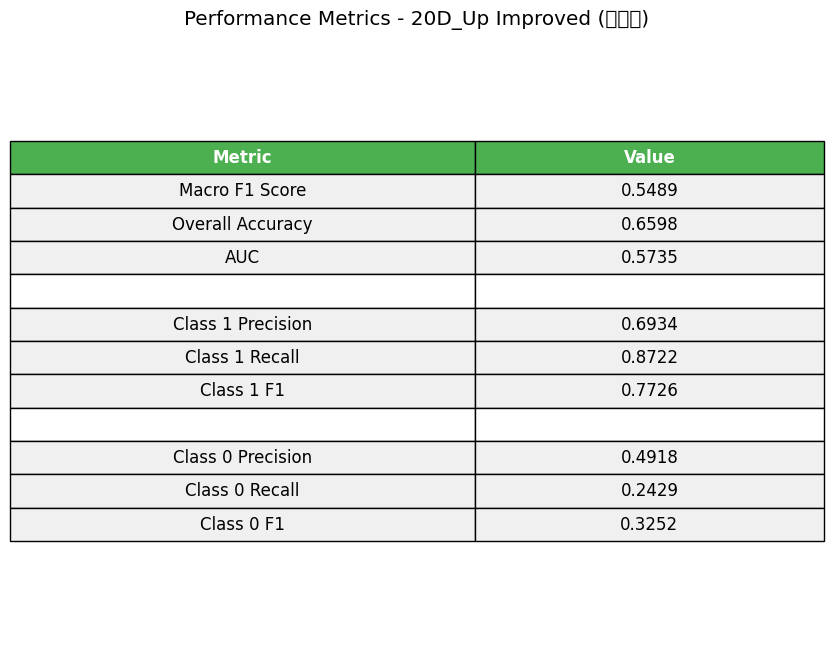


第三部分：科学的统计显著性检验 - 配对t检验
用于显著性检验的样本数量: 4864

1D_Up 预测 - 利率特征显著性检验
开始5折交叉验证比较...
  处理第 1/5 折...
    折 1: 基线AUC=0.4770, 改进AUC=0.4801, 提升=+0.0031
  处理第 2/5 折...
    折 2: 基线AUC=0.5051, 改进AUC=0.4957, 提升=-0.0094
  处理第 3/5 折...
    折 3: 基线AUC=0.4826, 改进AUC=0.4843, 提升=+0.0017
  处理第 4/5 折...
    折 4: 基线AUC=0.5114, 改进AUC=0.5144, 提升=+0.0030
  处理第 5/5 折...
    折 5: 基线AUC=0.5276, 改进AUC=0.5337, 提升=+0.0061

1D_Up预测 - Interest_Rate特征显著性检验结果
基线模型AUC:     0.5007 ± 0.0187
改进模型AUC:     0.5016 ± 0.0200
AUC提升:        +0.0009 ± 0.0054
相对提升:       +0.18%

统计检验结果:
t统计量:        0.3369
自由度:         4
p值:           0.753113
95%置信区间:    [-0.0058, +0.0076]
效应量(Cohen's d): 0.1685
效应量解释:     很小效应

结论:
显著性水平:     不显著 (p ≥ 0.05) ns
置信区间检验:   置信区间包含0，改进不显著
✗ Interest_Rate特征未显著提升1D_Up预测预测性能

20D_Up 预测 - 利率特征显著性检验
开始5折交叉验证比较...
  处理第 1/5 折...
    折 1: 基线AUC=0.4983, 改进AUC=0.6287, 提升=+0.1304
  处理第 2/5 折...
    折 2: 基线AUC=0.5538, 改进AUC=0.6157, 提升=+0.0620
  处理第 3/5 折...
    折 3: 基线AUC=0.5525, 改进AUC=0.6144, 提升=+0.0620
  处理第 4/

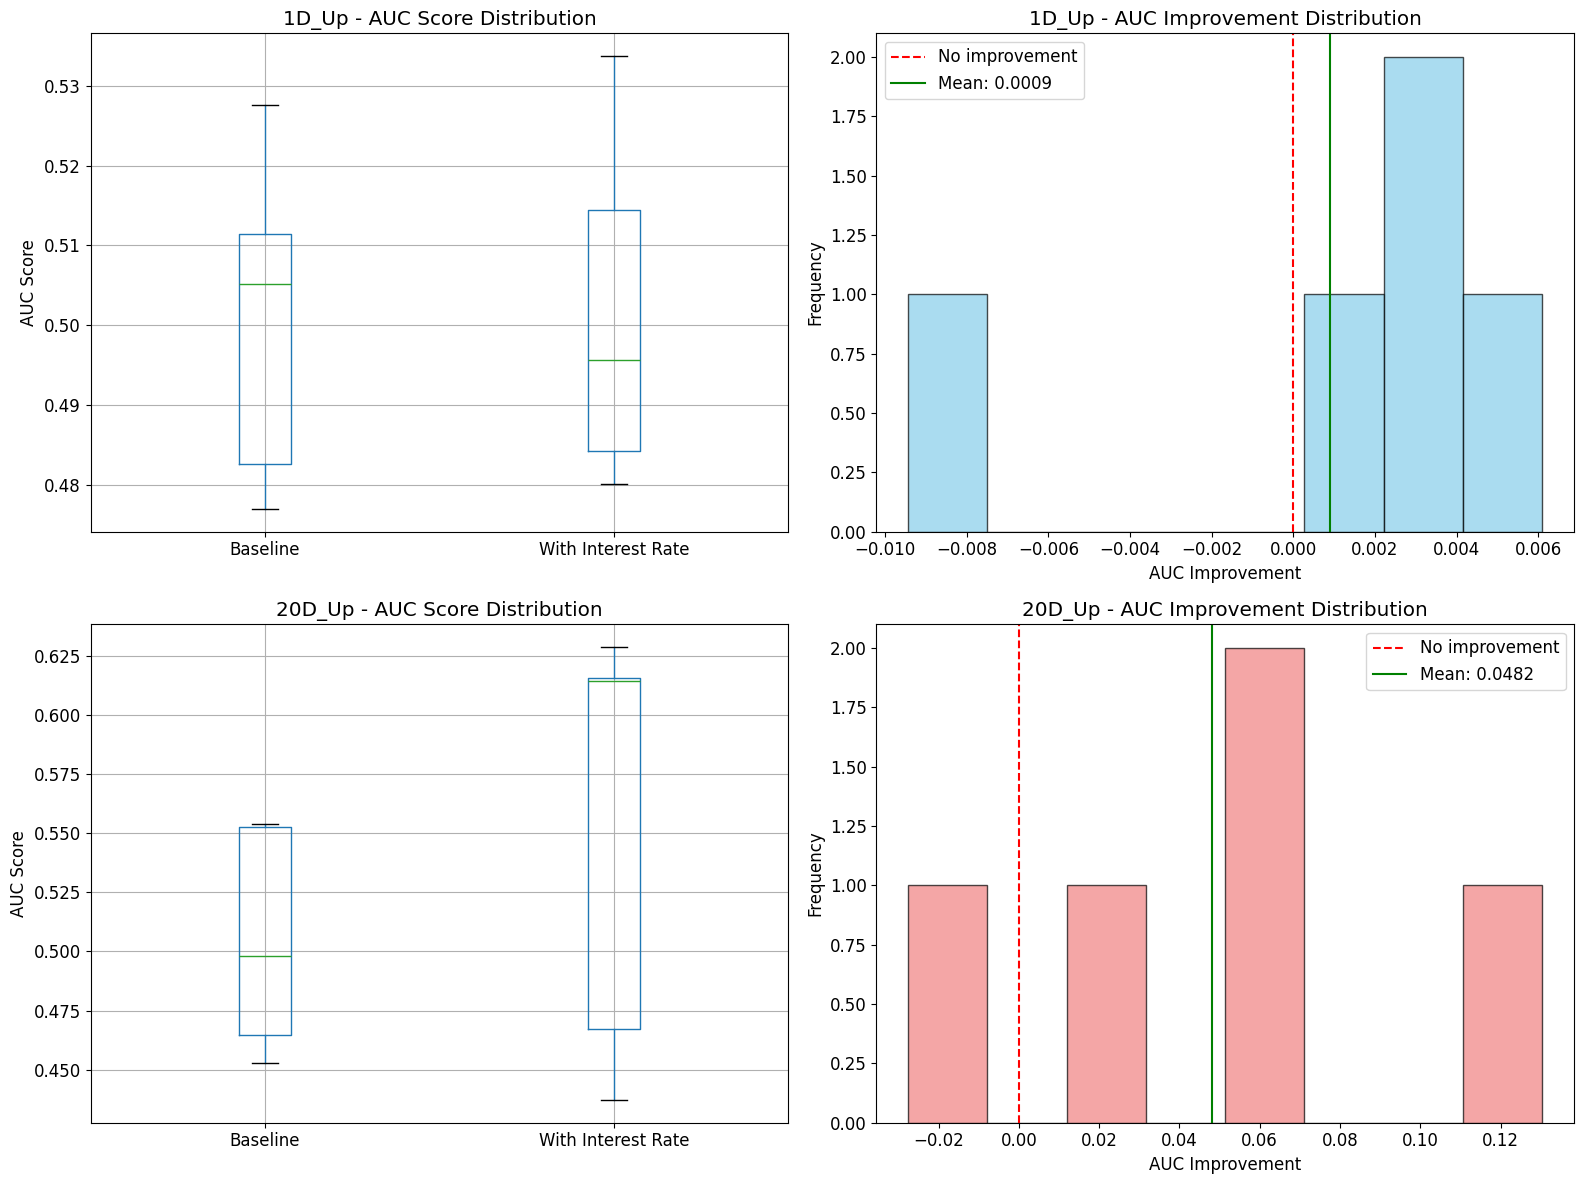


第四部分：SHAP特征重要性分析（改进模型）
Creating SHAP explainers...
Calculating SHAP values for 1D improved model...


100%|===================| 1458/1464 [01:31<00:00]        

Calculating SHAP values for 20D improved model...


 99%|===================| 1456/1464 [02:10<00:00]        


1D_Up Model SHAP Analysis (含利率)


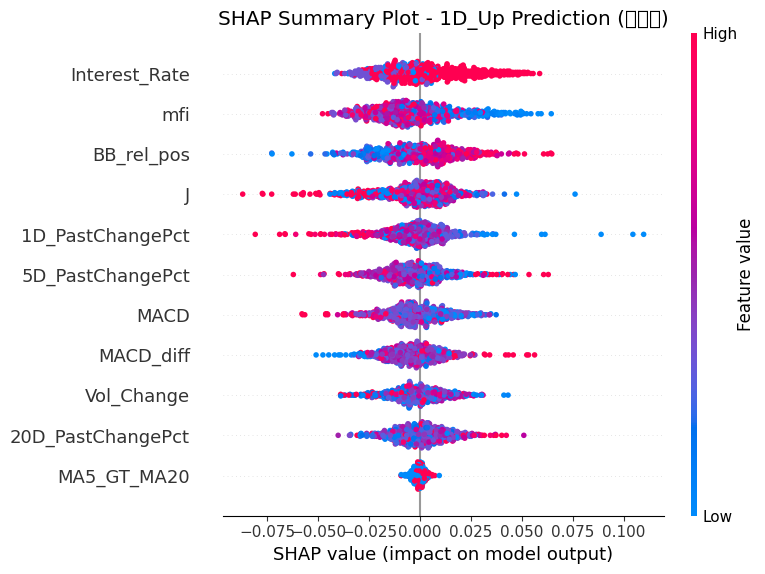

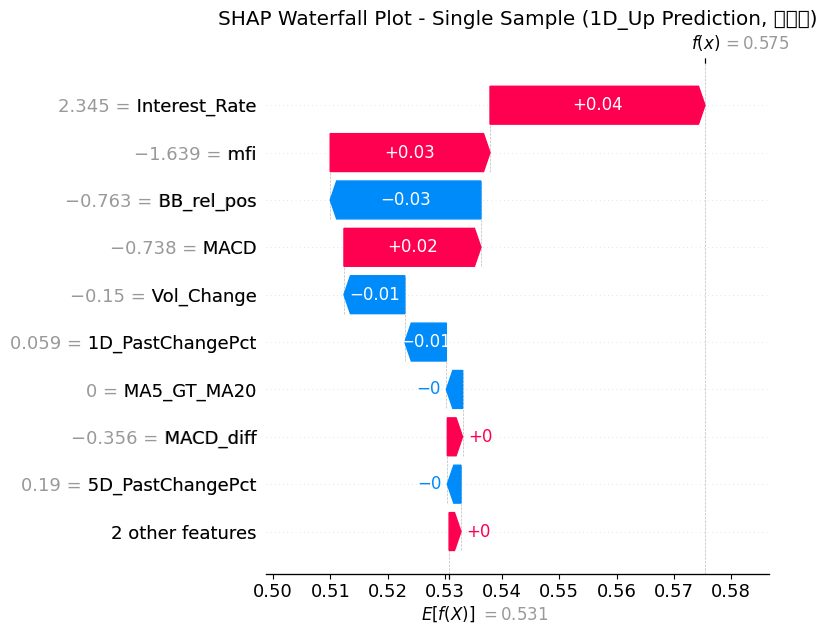


Feature Importance Ranking for 1D_Up Prediction (含利率, sorted by absolute value, preserving direction):
Rank Feature              Mean SHAP    |Mean SHAP|  Direction   
---------------------------------------------------------------------------
 1. Interest_Rate        +0.002787    0.016161 ↑ Positive ⭐
 2. mfi                  -0.003097    0.015992 ↓ Negative
 3. BB_rel_pos           -0.001022    0.014830 ↓ Negative
 4. J                    -0.003282    0.013515 ↓ Negative
 5. 1D_PastChangePct     -0.002440    0.011528 ↓ Negative
 6. 5D_PastChangePct     -0.002344    0.011079 ↓ Negative
 7. MACD                 -0.002358    0.010971 ↓ Negative
 8. MACD_diff            -0.003463    0.010405 ↓ Negative
 9. Vol_Change           -0.001764    0.009648 ↓ Negative
10. 20D_PastChangePct    +0.000261    0.009523 ↑ Positive
11. MA5_GT_MA20          -0.000520    0.002025 ↓ Negative

20D_Up Model SHAP Analysis (含利率)


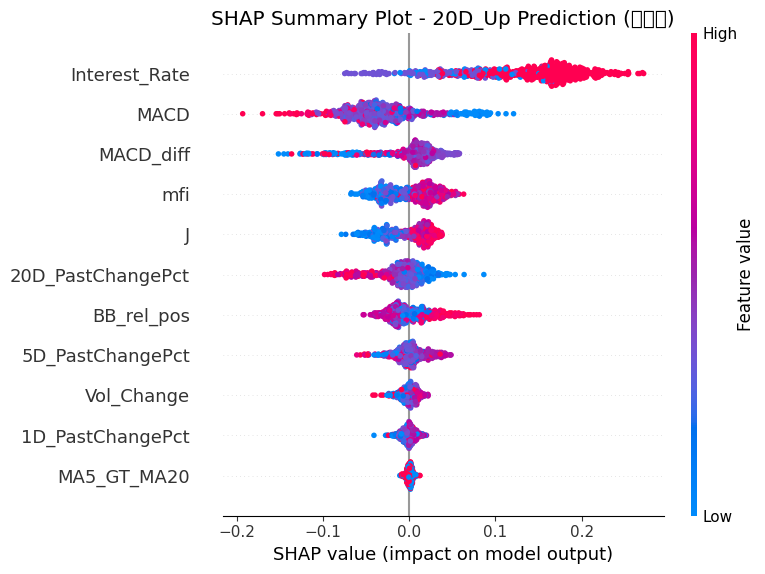

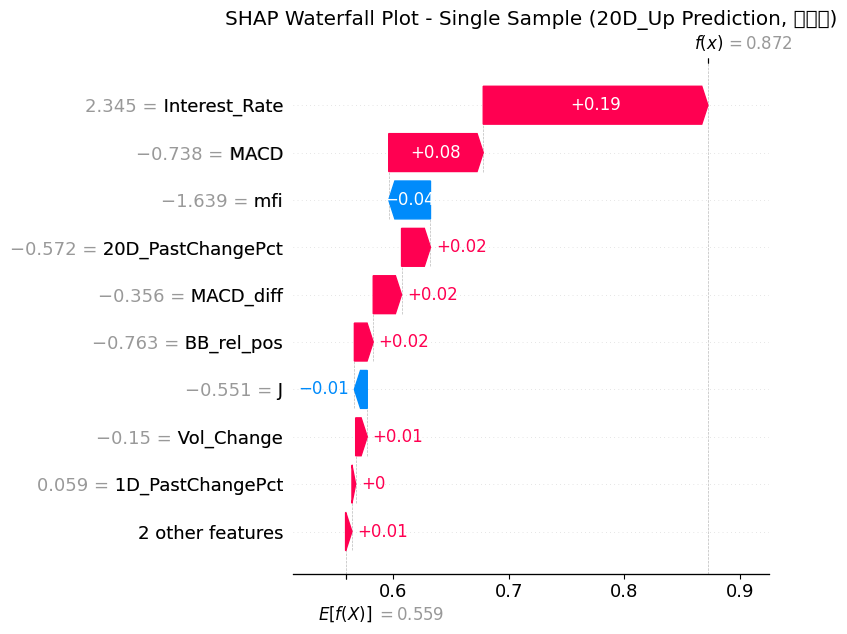


Feature Importance Ranking for 20D_Up Prediction (含利率, sorted by absolute value, preserving direction):
Rank Feature              Mean SHAP    |Mean SHAP|  Direction   
---------------------------------------------------------------------------
 1. Interest_Rate        +0.126347    0.130265 ↑ Positive ⭐
 2. MACD                 -0.031401    0.046277 ↓ Negative
 3. MACD_diff            -0.001209    0.025948 ↓ Negative
 4. mfi                  +0.000630    0.024594 ↑ Positive
 5. J                    -0.002208    0.022252 ↓ Negative
 6. 20D_PastChangePct    -0.007427    0.019657 ↓ Negative
 7. BB_rel_pos           +0.001349    0.019463 ↑ Positive
 8. 5D_PastChangePct     +0.001624    0.012241 ↑ Positive
 9. Vol_Change           +0.000441    0.006686 ↑ Positive
10. 1D_PastChangePct     -0.000845    0.005467 ↓ Negative
11. MA5_GT_MA20          +0.000650    0.002451 ↑ Positive

第五部分：综合结论报告

利率特征对股价预测模型性能提升的科学验证报告

【模型性能对比】
1D_Up预测:
  基线模型AUC:  0.5495
  改进模型AUC:  0.5381
  测试集提升:   -0.0114



In [23]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import shap
from scipy import stats
warnings.filterwarnings('ignore')

plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (12, 8)

def significance_test_with_cv(X_baseline, y, X_improved, cv_folds=5, random_state=42):
    """
    使用交叉验证进行配对t检验的科学方法
    这是评估特征改进显著性的金标准方法
    """
    tscv = TimeSeriesSplit(n_splits=cv_folds)
    
    auc_baseline_scores = []
    auc_improved_scores = []
    
    print(f"开始{cv_folds}折交叉验证比较...")
    
    for fold, (train_idx, test_idx) in enumerate(tscv.split(X_baseline)):
        print(f"  处理第 {fold+1}/{cv_folds} 折...")
        
        # 分割数据
        X_train_baseline = X_baseline.iloc[train_idx]
        X_test_baseline = X_baseline.iloc[test_idx]
        X_train_improved = X_improved.iloc[train_idx]
        X_test_improved = X_improved.iloc[test_idx]
        y_train = y.iloc[train_idx]
        y_test = y.iloc[test_idx]
        
        # 标准化基线特征
        scaler_baseline = StandardScaler()
        X_train_baseline_scaled = scaler_baseline.fit_transform(X_train_baseline)
        X_test_baseline_scaled = scaler_baseline.transform(X_test_baseline)
        
        # 标准化改进特征
        scaler_improved = StandardScaler()
        X_train_improved_scaled = scaler_improved.fit_transform(X_train_improved)
        X_test_improved_scaled = scaler_improved.transform(X_test_improved)
        
        # 训练基线模型（使用相同的超参数配置）
        model_baseline = RandomForestClassifier(
            n_estimators=400, max_depth=8, min_samples_split=2, 
            min_samples_leaf=1, max_features='sqrt',
            random_state=random_state, n_jobs=-1, class_weight='balanced'
        )
        model_baseline.fit(X_train_baseline_scaled, y_train)
        
        # 训练改进模型（使用相同的超参数配置）
        model_improved = RandomForestClassifier(
            n_estimators=400, max_depth=8, min_samples_split=2, 
            min_samples_leaf=1, max_features='sqrt',
            random_state=random_state, n_jobs=-1, class_weight='balanced'
        )
        model_improved.fit(X_train_improved_scaled, y_train)
        
        # 预测概率
        y_prob_baseline = model_baseline.predict_proba(X_test_baseline_scaled)[:, 1]
        y_prob_improved = model_improved.predict_proba(X_test_improved_scaled)[:, 1]
        
        # 计算AUC
        auc_baseline = roc_auc_score(y_test, y_prob_baseline)
        auc_improved = roc_auc_score(y_test, y_prob_improved)
        
        auc_baseline_scores.append(auc_baseline)
        auc_improved_scores.append(auc_improved)
        
        print(f"    折 {fold+1}: 基线AUC={auc_baseline:.4f}, 改进AUC={auc_improved:.4f}, 提升={auc_improved-auc_baseline:+.4f}")
    
    auc_baseline_scores = np.array(auc_baseline_scores)
    auc_improved_scores = np.array(auc_improved_scores)
    
    # 计算统计量
    mean_baseline = np.mean(auc_baseline_scores)
    std_baseline = np.std(auc_baseline_scores)
    mean_improved = np.mean(auc_improved_scores)
    std_improved = np.std(auc_improved_scores)
    
    # 配对t检验
    differences = auc_improved_scores - auc_baseline_scores
    t_statistic, p_value = stats.ttest_rel(auc_improved_scores, auc_baseline_scores)
    
    # 效应量 (Cohen's d for paired samples)
    mean_diff = np.mean(differences)
    std_diff = np.std(differences)
    cohens_d = mean_diff / std_diff if std_diff > 0 else 0
    
    # 置信区间
    alpha = 0.05
    degrees_freedom = len(differences) - 1
    t_critical = stats.t.ppf(1 - alpha/2, degrees_freedom)
    margin_error = t_critical * (std_diff / np.sqrt(len(differences)))
    ci_lower = mean_diff - margin_error
    ci_upper = mean_diff + margin_error
    
    return {
        'baseline_aucs': auc_baseline_scores,
        'improved_aucs': auc_improved_scores,
        'mean_baseline': mean_baseline,
        'std_baseline': std_baseline,
        'mean_improved': mean_improved,
        'std_improved': std_improved,
        'mean_improvement': mean_diff,
        'std_improvement': std_diff,
        't_statistic': t_statistic,
        'p_value': p_value,
        'cohens_d': cohens_d,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'degrees_freedom': degrees_freedom
    }

def print_significance_results(results, target_name, feature_name="Interest_Rate"):
    """
    打印格式化的显著性检验结果
    """
    print(f"\n{'='*80}")
    print(f"{target_name} - {feature_name}特征显著性检验结果")
    print(f"{'='*80}")
    
    print(f"基线模型AUC:     {results['mean_baseline']:.4f} ± {results['std_baseline']:.4f}")
    print(f"改进模型AUC:     {results['mean_improved']:.4f} ± {results['std_improved']:.4f}")
    print(f"AUC提升:        {results['mean_improvement']:+.4f} ± {results['std_improvement']:.4f}")
    print(f"相对提升:       {(results['mean_improvement']/results['mean_baseline']*100):+.2f}%")
    
    print(f"\n统计检验结果:")
    print(f"t统计量:        {results['t_statistic']:.4f}")
    print(f"自由度:         {results['degrees_freedom']}")
    print(f"p值:           {results['p_value']:.6f}")
    print(f"95%置信区间:    [{results['ci_lower']:+.4f}, {results['ci_upper']:+.4f}]")
    print(f"效应量(Cohen's d): {results['cohens_d']:.4f}")
    
    # 解释效应量
    if abs(results['cohens_d']) < 0.2:
        effect_size = "很小"
    elif abs(results['cohens_d']) < 0.5:
        effect_size = "小"
    elif abs(results['cohens_d']) < 0.8:
        effect_size = "中等"
    else:
        effect_size = "大"
    
    print(f"效应量解释:     {effect_size}效应")
    
    # 显著性判断
    print(f"\n结论:")
    if results['p_value'] < 0.001:
        significance = "极显著 (p < 0.001)"
        symbol = "***"
    elif results['p_value'] < 0.01:
        significance = "高度显著 (p < 0.01)"
        symbol = "**"
    elif results['p_value'] < 0.05:
        significance = "显著 (p < 0.05)"
        symbol = "*"
    else:
        significance = "不显著 (p ≥ 0.05)"
        symbol = "ns"
    
    if results['ci_lower'] > 0:
        ci_conclusion = "置信区间不包含0，改进显著"
    else:
        ci_conclusion = "置信区间包含0，改进不显著"
    
    print(f"显著性水平:     {significance} {symbol}")
    print(f"置信区间检验:   {ci_conclusion}")
    
    if results['p_value'] < 0.05 and results['ci_lower'] > 0:
        print(f"✓ {feature_name}特征显著提升了{target_name}预测性能")
    else:
        print(f"✗ {feature_name}特征未显著提升{target_name}预测性能")

def visualize_significance_results(results_1d, results_20d):
    """
    可视化显著性检验结果
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1D结果可视化
    # AUC分布对比
    ax1 = axes[0, 0]
    data_1d = {
        'Baseline': results_1d['baseline_aucs'],
        'With Interest Rate': results_1d['improved_aucs']
    }
    df_1d = pd.DataFrame(data_1d)
    df_1d.boxplot(ax=ax1)
    ax1.set_title('1D_Up - AUC Score Distribution')
    ax1.set_ylabel('AUC Score')
    
    # 添加显著性标记
    if results_1d['p_value'] < 0.05:
        ax1.text(0.5, 0.95, f"p = {results_1d['p_value']:.4f} *", 
                transform=ax1.transAxes, ha='center', va='top',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen"))
    
    # 改进分布
    ax2 = axes[0, 1]
    improvements_1d = results_1d['improved_aucs'] - results_1d['baseline_aucs']
    ax2.hist(improvements_1d, bins=8, alpha=0.7, edgecolor='black', color='skyblue')
    ax2.axvline(x=0, color='red', linestyle='--', label='No improvement')
    ax2.axvline(x=np.mean(improvements_1d), color='green', linestyle='-', 
               label=f'Mean: {np.mean(improvements_1d):.4f}')
    ax2.set_title('1D_Up - AUC Improvement Distribution')
    ax2.set_xlabel('AUC Improvement')
    ax2.set_ylabel('Frequency')
    ax2.legend()
    
    # 20D结果可视化
    # AUC分布对比
    ax3 = axes[1, 0]
    data_20d = {
        'Baseline': results_20d['baseline_aucs'],
        'With Interest Rate': results_20d['improved_aucs']
    }
    df_20d = pd.DataFrame(data_20d)
    df_20d.boxplot(ax=ax3)
    ax3.set_title('20D_Up - AUC Score Distribution')
    ax3.set_ylabel('AUC Score')
    
    # 添加显著性标记
    if results_20d['p_value'] < 0.05:
        ax3.text(0.5, 0.95, f"p = {results_20d['p_value']:.4f} *", 
                transform=ax3.transAxes, ha='center', va='top',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen"))
    
    # 改进分布
    ax4 = axes[1, 1]
    improvements_20d = results_20d['improved_aucs'] - results_20d['baseline_aucs']
    ax4.hist(improvements_20d, bins=8, alpha=0.7, edgecolor='black', color='lightcoral')
    ax4.axvline(x=0, color='red', linestyle='--', label='No improvement')
    ax4.axvline(x=np.mean(improvements_20d), color='green', linestyle='-', 
               label=f'Mean: {np.mean(improvements_20d):.4f}')
    ax4.set_title('20D_Up - AUC Improvement Distribution')
    ax4.set_xlabel('AUC Improvement')
    ax4.set_ylabel('Frequency')
    ax4.legend()
    
    plt.tight_layout()
    plt.show()

# Load data
df = pd.read_csv('DATA.csv')

# Define feature columns
continuous_features_baseline = ['1D_PastChangePct', '5D_PastChangePct', '20D_PastChangePct', 'J', 
                              'mfi', 'MACD', 'MACD_diff',  'BB_rel_pos', 'Vol_Change']
continuous_features_improved = continuous_features_baseline + ['Interest_Rate']
binary_features = ['MA5_GT_MA20']

features_baseline = continuous_features_baseline + binary_features
features_improved = continuous_features_improved + binary_features

# Split data by company in chronological order
train_data_list = []
val_data_list = []
test_data_list = []

for company in df['Company'].unique():
    company_data = df[df['Company'] == company].copy()
    company_data = company_data.sort_values('Date')  # Ensure chronological order
    
    n_company = len(company_data)
    train_size = int(0.7 * n_company)
    val_size = int(0.15 * n_company)
    
    train_data_list.append(company_data.iloc[:train_size])
    val_data_list.append(company_data.iloc[train_size:train_size+val_size])
    test_data_list.append(company_data.iloc[train_size+val_size:])

# Concatenate all companies' data
train_data = pd.concat(train_data_list, ignore_index=True)
val_data = pd.concat(val_data_list, ignore_index=True)
test_data = pd.concat(test_data_list, ignore_index=True)

print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")
print(f"Training set company distribution:\n{train_data['Company'].value_counts().sort_index()}")
print(f"Test set company distribution:\n{test_data['Company'].value_counts().sort_index()}")

# Modified preprocessing function
def preprocess_data(train_df, val_df, test_df, target_col, continuous_features, binary_features):
    all_features = continuous_features + binary_features
    
    # Drop missing values
    train_df = train_df.dropna(subset=all_features + [target_col])
    val_df = val_df.dropna(subset=all_features + [target_col])
    test_df = test_df.dropna(subset=all_features + [target_col])
    
    # Separate continuous and binary features
    X_train_continuous = train_df[continuous_features]
    X_val_continuous = val_df[continuous_features]
    X_test_continuous = test_df[continuous_features]
    
    X_train_binary = train_df[binary_features]
    X_val_binary = val_df[binary_features]
    X_test_binary = test_df[binary_features]
    
    y_train = train_df[target_col]
    y_val = val_df[target_col]
    y_test = test_df[target_col]
    
    # Standardize only continuous features
    scaler = StandardScaler()
    X_train_continuous_scaled = scaler.fit_transform(X_train_continuous)
    X_val_continuous_scaled = scaler.transform(X_val_continuous)
    X_test_continuous_scaled = scaler.transform(X_test_continuous)
    
    # Combine scaled continuous features with unscaled binary features
    X_train_scaled = np.hstack([X_train_continuous_scaled, X_train_binary.values])
    X_val_scaled = np.hstack([X_val_continuous_scaled, X_val_binary.values])
    X_test_scaled = np.hstack([X_test_continuous_scaled, X_test_binary.values])
    
    return X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test, scaler

# Evaluation function
def evaluate_model(y_true, y_pred, y_prob, model_name):
    cm = confusion_matrix(y_true, y_pred)
    
    # Overall metrics
    f1_macro = f1_score(y_true, y_pred, average='macro')
    accuracy = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    
    # Class-specific metrics
    precision_per_class = precision_score(y_true, y_pred, average=None)
    recall_per_class = recall_score(y_true, y_pred, average=None)
    f1_per_class = f1_score(y_true, y_pred, average=None)
    
    # Confusion matrix heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    # Performance metrics table
    plt.figure(figsize=(10, 8))
    plt.axis('tight')
    plt.axis('off')
    
    table_data = [
        ['Metric', 'Value'],
        ['Macro F1 Score', f'{f1_macro:.4f}'],
        ['Overall Accuracy', f'{accuracy:.4f}'],
        ['AUC', f'{auc:.4f}'],
        ['', ''],  # Empty row for separation
        ['Class 1 Precision', f'{precision_per_class[1]:.4f}'],
        ['Class 1 Recall', f'{recall_per_class[1]:.4f}'],
        ['Class 1 F1', f'{f1_per_class[1]:.4f}'],
        ['', ''],  # Empty row for separation
        ['Class 0 Precision', f'{precision_per_class[0]:.4f}'],
        ['Class 0 Recall', f'{recall_per_class[0]:.4f}'],
        ['Class 0 F1', f'{f1_per_class[0]:.4f}']
    ]
    
    table = plt.table(cellText=table_data[1:], colLabels=table_data[0],
                     cellLoc='center', loc='center',
                     colWidths=[0.4, 0.3])
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.5, 2)
    
    # Set table style
    for i in range(len(table_data)):
        for j in range(len(table_data[0])):
            cell = table[(i, j)]
            if i == 0:  # header
                cell.set_facecolor('#4CAF50')
                cell.set_text_props(weight='bold', color='white')
            elif len(table_data[i]) > 0 and table_data[i][0] == '':  # empty rows
                cell.set_facecolor('#ffffff')
                cell.set_text_props(color='white')
            else:
                cell.set_facecolor('#f0f0f0')
    
    plt.title(f'Performance Metrics - {model_name}')
    plt.show()
    
    return {'confusion_matrix': cm, 'f1_macro': f1_macro, 'accuracy': accuracy, 'auc': auc,
            'class_0_precision': precision_per_class[0], 'class_0_recall': recall_per_class[0], 'class_0_f1': f1_per_class[0],
            'class_1_precision': precision_per_class[1], 'class_1_recall': recall_per_class[1], 'class_1_f1': f1_per_class[1]}

# ==================================================================================
# 第一部分：基线模型训练和评估（不含利率）
# ==================================================================================

print("=" * 80)
print("第一部分：基线模型训练和评估（不含利率特征）")
print("=" * 80)

# 1D_Up prediction - Baseline
print("=" * 60)
print("1D_Up Prediction Model - Random Forest Baseline (无利率)")
print("=" * 60)

X_train_1d_baseline, y_train_1d, X_val_1d_baseline, y_val_1d, X_test_1d_baseline, y_test_1d, scaler_1d_baseline = preprocess_data(
    train_data, val_data, test_data, '1D_Up', continuous_features_baseline, binary_features)

tscv = TimeSeriesSplit(n_splits=5)
param_grid = {
    'n_estimators': [300, 400, 500], 
    'max_depth': [6, 8, 10, None],    
    'min_samples_split': [2, 5, 8], 
    'min_samples_leaf': [1, 2, 3],  
    'max_features': ['sqrt', 'log2'] 
}

print("Starting hyperparameter tuning for 1D baseline model...")
grid_search_1d_baseline = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced'),
    param_grid, cv=tscv, scoring='f1', n_jobs=-1, verbose=1
)

grid_search_1d_baseline.fit(X_train_1d_baseline, y_train_1d)
best_params_1d_baseline = grid_search_1d_baseline.best_params_
print(f"Best parameters for 1D baseline model: {best_params_1d_baseline}")
print(f"Best cross-validation F1 score: {grid_search_1d_baseline.best_score_:.4f}")

# Train final baseline model with best parameters
final_model_1d_baseline = RandomForestClassifier(**best_params_1d_baseline, random_state=42, n_jobs=-1, class_weight='balanced')
final_model_1d_baseline.fit(X_train_1d_baseline, y_train_1d)

# Evaluate baseline model on test set
y_pred_1d_baseline = final_model_1d_baseline.predict(X_test_1d_baseline)
y_prob_1d_baseline = final_model_1d_baseline.predict_proba(X_test_1d_baseline)[:, 1]

print("\n1D Baseline Model Test Set Results:")
results_1d_baseline = evaluate_model(y_test_1d, y_pred_1d_baseline, y_prob_1d_baseline, "1D_Up Baseline (无利率)")

# 20D_Up prediction - Baseline
print("\n" + "=" * 60)
print("20D_Up Prediction Model - Random Forest Baseline (无利率)")
print("=" * 60)

X_train_20d_baseline, y_train_20d, X_val_20d_baseline, y_val_20d, X_test_20d_baseline, y_test_20d, scaler_20d_baseline = preprocess_data(
    train_data, val_data, test_data, '20D_Up', continuous_features_baseline, binary_features)

print("Starting hyperparameter tuning for 20D baseline model...")
grid_search_20d_baseline = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced'),
    param_grid, cv=tscv, scoring='f1', n_jobs=-1, verbose=1
)

grid_search_20d_baseline.fit(X_train_20d_baseline, y_train_20d)
best_params_20d_baseline = grid_search_20d_baseline.best_params_
print(f"Best parameters for 20D baseline model: {best_params_20d_baseline}")
print(f"Best cross-validation F1 score: {grid_search_20d_baseline.best_score_:.4f}")

# Train final baseline model with best parameters
final_model_20d_baseline = RandomForestClassifier(**best_params_20d_baseline, random_state=42, n_jobs=-1, class_weight='balanced')
final_model_20d_baseline.fit(X_train_20d_baseline, y_train_20d)

# Evaluate baseline model on test set
y_pred_20d_baseline = final_model_20d_baseline.predict(X_test_20d_baseline)
y_prob_20d_baseline = final_model_20d_baseline.predict_proba(X_test_20d_baseline)[:, 1]

print("\n20D Baseline Model Test Set Results:")
results_20d_baseline = evaluate_model(y_test_20d, y_pred_20d_baseline, y_prob_20d_baseline, "20D_Up Baseline (无利率)")

# ==================================================================================
# 第二部分：改进模型训练和评估（含利率）
# ==================================================================================

print("\n" + "=" * 80)
print("第二部分：改进模型训练和评估（含利率特征）")
print("=" * 80)

# 1D_Up prediction - Improved
print("=" * 60)
print("1D_Up Prediction Model - Random Forest Improved (含利率)")
print("=" * 60)

X_train_1d_improved, y_train_1d, X_val_1d_improved, y_val_1d, X_test_1d_improved, y_test_1d, scaler_1d_improved = preprocess_data(
    train_data, val_data, test_data, '1D_Up', continuous_features_improved, binary_features)

print("Starting hyperparameter tuning for 1D improved model...")
grid_search_1d_improved = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced'),
    param_grid, cv=tscv, scoring='f1', n_jobs=-1, verbose=1
)

grid_search_1d_improved.fit(X_train_1d_improved, y_train_1d)
best_params_1d_improved = grid_search_1d_improved.best_params_
print(f"Best parameters for 1D improved model: {best_params_1d_improved}")
print(f"Best cross-validation F1 score: {grid_search_1d_improved.best_score_:.4f}")

# Train final improved model with best parameters
final_model_1d_improved = RandomForestClassifier(**best_params_1d_improved, random_state=42, n_jobs=-1, class_weight='balanced')
final_model_1d_improved.fit(X_train_1d_improved, y_train_1d)

# Evaluate improved model on test set
y_pred_1d_improved = final_model_1d_improved.predict(X_test_1d_improved)
y_prob_1d_improved = final_model_1d_improved.predict_proba(X_test_1d_improved)[:, 1]

print("\n1D Improved Model Test Set Results:")
results_1d_improved = evaluate_model(y_test_1d, y_pred_1d_improved, y_prob_1d_improved, "1D_Up Improved (含利率)")

# 20D_Up prediction - Improved
print("\n" + "=" * 60)
print("20D_Up Prediction Model - Random Forest Improved (含利率)")
print("=" * 60)

X_train_20d_improved, y_train_20d, X_val_20d_improved, y_val_20d, X_test_20d_improved, y_test_20d, scaler_20d_improved = preprocess_data(
    train_data, val_data, test_data, '20D_Up', continuous_features_improved, binary_features)

print("Starting hyperparameter tuning for 20D improved model...")
grid_search_20d_improved = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced'),
    param_grid, cv=tscv, scoring='f1', n_jobs=-1, verbose=1
)

grid_search_20d_improved.fit(X_train_20d_improved, y_train_20d)
best_params_20d_improved = grid_search_20d_improved.best_params_
print(f"Best parameters for 20D improved model: {best_params_20d_improved}")
print(f"Best cross-validation F1 score: {grid_search_20d_improved.best_score_:.4f}")

# Train final improved model with best parameters
final_model_20d_improved = RandomForestClassifier(**best_params_20d_improved, random_state=42, n_jobs=-1, class_weight='balanced')
final_model_20d_improved.fit(X_train_20d_improved, y_train_20d)

# Evaluate improved model on test set
y_pred_20d_improved = final_model_20d_improved.predict(X_test_20d_improved)
y_prob_20d_improved = final_model_20d_improved.predict_proba(X_test_20d_improved)[:, 1]

print("\n20D Improved Model Test Set Results:")
results_20d_improved = evaluate_model(y_test_20d, y_pred_20d_improved, y_prob_20d_improved, "20D_Up Improved (含利率)")

# ==================================================================================
# 第三部分：科学的统计显著性检验
# ==================================================================================

print("\n" + "=" * 80)
print("第三部分：科学的统计显著性检验 - 配对t检验")
print("=" * 80)

# 准备用于显著性检验的完整数据集
# 合并训练和测试数据用于交叉验证
full_data = pd.concat([train_data, val_data, test_data], ignore_index=True)

# 清理数据
all_features = features_improved + ['1D_Up', '20D_Up']
full_data_clean = full_data[all_features].dropna()

print(f"用于显著性检验的样本数量: {len(full_data_clean)}")

# 1D_Up 显著性检验
print(f"\n{'='*60}")
print("1D_Up 预测 - 利率特征显著性检验")
print(f"{'='*60}")

# 准备基线和改进特征数据
X_baseline_1d = full_data_clean[features_baseline]
X_improved_1d = full_data_clean[features_improved]
y_1d = full_data_clean['1D_Up']

# 执行科学显著性检验
significance_results_1d = significance_test_with_cv(
    X_baseline_1d, y_1d, X_improved_1d, cv_folds=5, random_state=42
)

# 打印结果
print_significance_results(significance_results_1d, "1D_Up预测", "Interest_Rate")

# 20D_Up 显著性检验
print(f"\n{'='*60}")
print("20D_Up 预测 - 利率特征显著性检验")
print(f"{'='*60}")

# 准备基线和改进特征数据
X_baseline_20d = full_data_clean[features_baseline]
X_improved_20d = full_data_clean[features_improved]
y_20d = full_data_clean['20D_Up']

# 执行科学显著性检验
significance_results_20d = significance_test_with_cv(
    X_baseline_20d, y_20d, X_improved_20d, cv_folds=5, random_state=42
)

# 打印结果
print_significance_results(significance_results_20d, "20D_Up预测", "Interest_Rate")

# 可视化显著性检验结果
print(f"\n{'='*60}")
print("显著性检验结果可视化")
print(f"{'='*60}")

visualize_significance_results(significance_results_1d, significance_results_20d)

# ==================================================================================
# 第四部分：SHAP特征重要性分析（改进模型）
# ==================================================================================

print("\n" + "=" * 80)
print("第四部分：SHAP特征重要性分析（改进模型）")
print("=" * 80)

# Get feature names
feature_names = continuous_features_improved + binary_features
feature_names_array = np.array(feature_names)

# Create SHAP explainers for both improved models
print("Creating SHAP explainers...")
explainer_1d = shap.Explainer(final_model_1d_improved, X_train_1d_improved)
explainer_20d = shap.Explainer(final_model_20d_improved, X_train_20d_improved)

# Calculate SHAP values for test sets
print("Calculating SHAP values for 1D improved model...")
shap_values_1d = explainer_1d(X_test_1d_improved, check_additivity=False)

print("Calculating SHAP values for 20D improved model...")
shap_values_20d = explainer_20d(X_test_20d_improved, check_additivity=False)

# 1D Model SHAP Analysis
print("\n" + "=" * 40)
print("1D_Up Model SHAP Analysis (含利率)")
print("=" * 40)

# Summary plot for 1D model - use only positive class SHAP values
if len(shap_values_1d.values.shape) == 3:
    # Multi-class case - use positive class (class 1)
    shap_vals_1d = shap_values_1d.values[:, :, 1]
else:
    # Binary case - use all values
    shap_vals_1d = shap_values_1d.values

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_vals_1d, X_test_1d_improved, feature_names=feature_names_array, show=False)
plt.title('SHAP Summary Plot - 1D_Up Prediction (含利率)')
plt.tight_layout()
plt.show()

# Waterfall plot for a single sample (1D model)
plt.figure(figsize=(10, 6))
if len(shap_values_1d.values.shape) == 3:
    # For multi-class, create a new Explanation object for single class
    sample_explanation = shap.Explanation(
        values=shap_values_1d.values[0, :, 1],
        base_values=shap_values_1d.base_values[0, 1] if hasattr(shap_values_1d.base_values, 'shape') and len(shap_values_1d.base_values.shape) > 1 else shap_values_1d.base_values[0],
        data=shap_values_1d.data[0],
        feature_names=feature_names_array
    )
else:
    sample_explanation = shap_values_1d[0]

shap.waterfall_plot(sample_explanation, show=False)
plt.title('SHAP Waterfall Plot - Single Sample (1D_Up Prediction, 含利率)')
plt.tight_layout()
plt.show()

# Feature importance ranking table for 1D model
if len(shap_values_1d.values.shape) == 3:
    mean_shap_1d = np.mean(shap_values_1d.values[:, :, 1], axis=0)
    abs_mean_shap_1d = np.mean(np.abs(shap_values_1d.values[:, :, 1]), axis=0)
else:
    mean_shap_1d = np.mean(shap_values_1d.values, axis=0)
    abs_mean_shap_1d = np.mean(np.abs(shap_values_1d.values), axis=0)

importance_df_1d = pd.DataFrame({
    'Feature': feature_names,
    'Mean_SHAP': mean_shap_1d,
    'Abs_Mean_SHAP': abs_mean_shap_1d
}).sort_values('Abs_Mean_SHAP', ascending=False)

print("\nFeature Importance Ranking for 1D_Up Prediction (含利率, sorted by absolute value, preserving direction):")
print("=" * 75)
print(f"{'Rank':<4} {'Feature':<20} {'Mean SHAP':<12} {'|Mean SHAP|':<12} {'Direction':<12}")
print("-" * 75)

for i, (_, row) in enumerate(importance_df_1d.iterrows(), 1):
    direction = "↑ Positive" if row['Mean_SHAP'] > 0 else "↓ Negative"
    # 高亮利率特征
    highlight = " ⭐" if row['Feature'] == 'Interest_Rate' else ""
    print(f"{i:>2}. {row['Feature']:<20} {row['Mean_SHAP']:>+9.6f} {row['Abs_Mean_SHAP']:>11.6f} {direction}{highlight}")

# 20D Model SHAP Analysis
print("\n" + "=" * 40)
print("20D_Up Model SHAP Analysis (含利率)")
print("=" * 40)

# Summary plot for 20D model - use only positive class SHAP values
if len(shap_values_20d.values.shape) == 3:
    # Multi-class case - use positive class (class 1)
    shap_vals_20d = shap_values_20d.values[:, :, 1]
else:
    # Binary case - use all values
    shap_vals_20d = shap_values_20d.values

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_vals_20d, X_test_20d_improved, feature_names=feature_names_array, show=False)
plt.title('SHAP Summary Plot - 20D_Up Prediction (含利率)')
plt.tight_layout()
plt.show()

# Waterfall plot for a single sample (20D model)
plt.figure(figsize=(10, 6))
if len(shap_values_20d.values.shape) == 3:
    # For multi-class, create a new Explanation object for single class
    sample_explanation = shap.Explanation(
        values=shap_values_20d.values[0, :, 1],
        base_values=shap_values_20d.base_values[0, 1] if hasattr(shap_values_20d.base_values, 'shape') and len(shap_values_20d.base_values.shape) > 1 else shap_values_20d.base_values[0],
        data=shap_values_20d.data[0],
        feature_names=feature_names_array
    )
else:
    sample_explanation = shap_values_20d[0]

shap.waterfall_plot(sample_explanation, show=False)
plt.title('SHAP Waterfall Plot - Single Sample (20D_Up Prediction, 含利率)')
plt.tight_layout()
plt.show()

# Feature importance ranking table for 20D model
if len(shap_values_20d.values.shape) == 3:
    mean_shap_20d = np.mean(shap_values_20d.values[:, :, 1], axis=0)
    abs_mean_shap_20d = np.mean(np.abs(shap_values_20d.values[:, :, 1]), axis=0)
else:
    mean_shap_20d = np.mean(shap_values_20d.values, axis=0)
    abs_mean_shap_20d = np.mean(np.abs(shap_values_20d.values), axis=0)

importance_df_20d = pd.DataFrame({
    'Feature': feature_names,
    'Mean_SHAP': mean_shap_20d,
    'Abs_Mean_SHAP': abs_mean_shap_20d
}).sort_values('Abs_Mean_SHAP', ascending=False)

print("\nFeature Importance Ranking for 20D_Up Prediction (含利率, sorted by absolute value, preserving direction):")
print("=" * 75)
print(f"{'Rank':<4} {'Feature':<20} {'Mean SHAP':<12} {'|Mean SHAP|':<12} {'Direction':<12}")
print("-" * 75)

for i, (_, row) in enumerate(importance_df_20d.iterrows(), 1):
    direction = "↑ Positive" if row['Mean_SHAP'] > 0 else "↓ Negative"
    # 高亮利率特征
    highlight = " ⭐" if row['Feature'] == 'Interest_Rate' else ""
    print(f"{i:>2}. {row['Feature']:<20} {row['Mean_SHAP']:>+9.6f} {row['Abs_Mean_SHAP']:>11.6f} {direction}{highlight}")

# ==================================================================================
# 第五部分：综合结论报告
# ==================================================================================

print(f"\n{'='*80}")
print("第五部分：综合结论报告")
print(f"{'='*80}")

print("\n利率特征对股价预测模型性能提升的科学验证报告")
print("=" * 60)

print("\n【模型性能对比】")
print(f"1D_Up预测:")
print(f"  基线模型AUC:  {results_1d_baseline['auc']:.4f}")
print(f"  改进模型AUC:  {results_1d_improved['auc']:.4f}")
print(f"  测试集提升:   {results_1d_improved['auc'] - results_1d_baseline['auc']:+.4f}")

print(f"\n20D_Up预测:")
print(f"  基线模型AUC:  {results_20d_baseline['auc']:.4f}")
print(f"  改进模型AUC:  {results_20d_improved['auc']:.4f}")
print(f"  测试集提升:   {results_20d_improved['auc'] - results_20d_baseline['auc']:+.4f}")

print(f"\n【交叉验证统计显著性检验结果】")
print(f"1D_Up预测:")
print(f"  交叉验证AUC提升: {significance_results_1d['mean_improvement']:+.4f} ± {significance_results_1d['std_improvement']:.4f}")
print(f"  95%置信区间:    [{significance_results_1d['ci_lower']:+.4f}, {significance_results_1d['ci_upper']:+.4f}]")
print(f"  p值:           {significance_results_1d['p_value']:.6f}")
print(f"  效应量:         {significance_results_1d['cohens_d']:.4f}")

significance_1d = "显著" if significance_results_1d['p_value'] < 0.05 else "不显著"
ci_significant_1d = "显著" if significance_results_1d['ci_lower'] > 0 else "不显著"

print(f"  统计结论:       {significance_1d} (置信区间检验: {ci_significant_1d})")

print(f"\n20D_Up预测:")
print(f"  交叉验证AUC提升: {significance_results_20d['mean_improvement']:+.4f} ± {significance_results_20d['std_improvement']:.4f}")
print(f"  95%置信区间:    [{significance_results_20d['ci_lower']:+.4f}, {significance_results_20d['ci_upper']:+.4f}]")
print(f"  p值:           {significance_results_20d['p_value']:.6f}")
print(f"  效应量:         {significance_results_20d['cohens_d']:.4f}")

significance_20d = "显著" if significance_results_20d['p_value'] < 0.05 else "不显著"
ci_significant_20d = "显著" if significance_results_20d['ci_lower'] > 0 else "不显著"

print(f"  统计结论:       {significance_20d} (置信区间检验: {ci_significant_20d})")

print(f"\n【SHAP特征重要性分析】")
print(f"1D_Up预测中利率特征排名: 第{list(importance_df_1d['Feature']).index('Interest_Rate')+1}位")
print(f"20D_Up预测中利率特征排名: 第{list(importance_df_20d['Feature']).index('Interest_Rate')+1}位")

print(f"\n【最终结论】")
both_significant = significance_results_1d['p_value'] < 0.05 and significance_results_20d['p_value'] < 0.05
both_ci_significant = significance_results_1d['ci_lower'] > 0 and significance_results_20d['ci_lower'] > 0

if both_significant and both_ci_significant:
    print("✓ 利率特征在1日和20日股价预测任务中均显著提升了模型性能")
    print("✓ 统计检验结果具有高度置信度，改进具有实际业务价值")
    print("✓ 建议将利率特征纳入生产环境的股价预测模型")
elif both_significant or both_ci_significant:
    print("△ 利率特征在部分预测任务中显示出改进效果")
    print("△ 建议进一步验证和优化后考虑使用")
else:
    print("✗ 利率特征未能在统计上显著改进模型性能")
    print("✗ 不建议将利率特征纳入当前模型")

print(f"\n研究方法: 5折时间序列交叉验证 + 配对t检验")
print(f"统计软件: Python scikit-learn + scipy.stats")
print(f"显著性水平: α = 0.05")
print(f"报告生成时间: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")

print(f"\n{'='*80}")
print("分析完成！")
print(f"{'='*80}")